In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install colormath

  Preparing metadata (setup.py) ... done
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39405 sha256=8908adc3f6666b2afc01080263c6cda1610231dceaafdbe30c0b384e19600b4d
  Stored in directory: /root/.cache/pip/wheels/ab/b3/4d/c0738759c25a1df01958068f162cf2a9dc3ab1da8b972cfcfc
Successfully built colormath


In [3]:
import datetime
import logging
import traceback

import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.metrics import r2_score
import pickle
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score
from colormath.color_objects import LabColor, sRGBColor, XYZColor, LabColor
from colormath.color_diff import delta_e_cmc
from colormath.color_conversions import convert_color

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

from PIL import Image
import math
from math import sqrt
import copy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Concatenate, Dropout, Lambda, Layer, LayerNormalization
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
# import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder,MinMaxScaler
import pandas.core.algorithms as algos
from pandas import Series
import pickle
#from pandas import tools

In [4]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU is available.")
else:
    print("No GPU detected.")


No GPU detected.


In [5]:
import warnings

# 모든 경고 무시
warnings.filterwarnings("ignore")

In [6]:
# gpu 상태 확인 및 메모리 사용만큼 할당
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [7]:
# lab를 rgb로 변환하는 함수
def lab_to_rgb(data):
    r_list=[]
    g_list=[]
    b_list=[]
    for i in range(len(data)):
        lab=LabColor(data[data.columns[0]][data.index[i]],data[data.columns[1]][data.index[i]],data[data.columns[2]][data.index[i]])#lab좌표
        rgb=convert_color(lab,sRGBColor)#rgb좌표
        rgb_list=[color for color in rgb.get_value_tuple()]
        r_list.append(rgb_list[0])
        g_list.append(rgb_list[1])
        b_list.append(rgb_list[2])
    df = pd.DataFrame(
                {'r' : r_list,
                 'g' : g_list,
                 'b' : b_list}
                )
    df.index=data.index
    return(df)

In [8]:
def cie94_color_difference(y_pred, y_true):
    """Calculate color difference by using CIE94 formulae

    See http://en.wikipedia.org/wiki/Color_difference or
    http://www.brucelindbloom.com/index.html?Eqn_DeltaE_CIE94.html.

    cie94(rgb2lab((255, 255, 255)), rgb2lab((0, 0, 0)))
    >>> 58.0
    cie94(rgb2lab(rgb(0xff0000)), rgb2lab(rgb('#ff0000')))
    >>> 0.0
    """

    L1, a1, b1 = y_true[0],y_true[1],y_true[2]
    L2, a2, b2 = y_pred[0],y_pred[1],y_pred[2]


    C1 = np.sqrt(a1**2 + b1**2)
    C2 = K.sqrt(K.pow(a2,2) + K.pow(b2,2))
    delta_L = L1 - L2
    delta_C = C1 - C2
    delta_a = a1 - a2
    delta_b = b1 - b2
    delta_H_square = delta_a**2 + delta_b**2 - delta_C**2
    loss_a = (np.sqrt((delta_L)**2
            + (delta_C)**2 / (1.0 + 0.045 * C1)**2
            + delta_H_square / (1.0 + 0.015 * C1)**2))
    return loss_a

In [9]:
def color_diff(pred_TRANS,Y_TRANS):
    diff = []
    for i in Y_TRANS.index:
        pred = list(pred_TRANS.loc[i])
        true = list(Y_TRANS.loc[i])
#        p_lab = LabColor(pred[0],pred[1],pred[2])
#        t_lab = LabColor(true[0],true[1],true[2])
        delta = cie94_color_difference(pred , true)
        diff.append(delta)
    diff=pd.DataFrame(diff)
    diff.index=Y_TRANS.index
    return(diff)

### data load

In [10]:
#데이터 불러오기
train=pd.read_csv('/content/drive/MyDrive/이어드림/공유_섬유염색예측/data/train_data.csv',encoding='euc-kr')
test=pd.read_csv('/content/drive/MyDrive/이어드림/공유_섬유염색예측/data/test_data.csv',encoding='euc-kr')
train


#shape 확인
print('train shape : ',train.shape)
print('test shape : ',test.shape)


#인덱스정보 따로 저장
train_index=train['index']
test_index=test['index']

#데이터 결합
data=pd.concat([train,test],axis=0)

# #index 제거
data=data.set_index(['index'])
data

train shape :  (3347, 174)
test shape :  (372, 174)


,소재_경사정보_V1,소재_경사정보_V2,소재_경사정보_V3,소재_경사정보_V4,소재_경사정보_V5,소재_경사정보_V6,소재_경사정보_V7,소재_경사정보_V8,소재_경사정보_V9,소재_경사정보_V10,...,배합_염료3_Black_prop,배합_염료1_Grey_prop,배합_염료2_Grey_prop,배합_염료3_Grey_prop,배합_염료2_Brown_prop,배합_염료1_Brown_prop,배합_염료3_Brown_prop,색상_L*,색상_a*,색상_b*
index,,,,,,,,,,,,,,,,,,,,,
0,PET 재생 섬유,300,96,Semi Dull,Draw Textured Yarn,88,Filaments,150,150,0,...,0,0,0,0,0,0,1,50.5100,10.5500,9.4800
2,PET 재생 섬유,300,96,Semi Dull,Draw Textured Yarn,88,Filaments,150,150,0,...,0,0,0,0,0,0,1,51.8700,10.2400,9.4800
3,PET 재생 섬유,300,96,Semi Dull,Draw Textured Yarn,88,Filaments,150,150,0,...,0,0,0,0,0,0,1,48.9300,10.9200,9.5700
4,PET 재생 섬유,300,96,Semi Dull,Draw Textured Yarn,88,Filaments,150,150,0,...,0,0,0,0,0,0,1,49.5800,10.5200,9.7900
5,PET 재생 섬유,300,96,Semi Dull,Draw Textured Yarn,88,Filaments,150,150,0,...,0,0,0,0,0,0,1,50.1000,10.6800,9.4900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3716,PET 재생 섬유,300,96,Semi Dull,Draw Textured Yarn,96,Filaments,150,150,0,...,0,0,0,0,0,0,0,77.0225,19.7130,79.1715
3718,PET 재생 섬유,300,96,Semi Dull,Draw Textured Yarn,96,Filaments,150,150,0,...,0,0,0,0,0,0,0,76.7375,19.3850,78.4980
3719,PET 재생 섬유,300,96,Semi Dull,Draw Textured Yarn,96,Filaments,150,150,0,...,0,0,0,0,0,0,0,76.6140,19.1140,77.9200


In [11]:
df = train[train["배합_조제_V2"] == 0]
df

,index,소재_경사정보_V1,소재_경사정보_V2,소재_경사정보_V3,소재_경사정보_V4,소재_경사정보_V5,소재_경사정보_V6,소재_경사정보_V7,소재_경사정보_V8,소재_경사정보_V9,...,배합_염료3_Black_prop,배합_염료1_Grey_prop,배합_염료2_Grey_prop,배합_염료3_Grey_prop,배합_염료2_Brown_prop,배합_염료1_Brown_prop,배합_염료3_Brown_prop,색상_L*,색상_a*,색상_b*
1519,1715,PET 재생 섬유,300,96,Semi Dull,Draw Textured Yarn,88,Filaments,150,150,...,0,0,0,0,0,0,0,25.420,8.9475,-22.77125
1558,1756,PET 재생 섬유,300,96,Semi Dull,Draw Textured Yarn,88,Filaments,150,150,...,0,0,0,0,0,0,0,26.075,20.0275,-15.02750
1790,2010,PET 재생 섬유,300,96,Semi Dull,Draw Textured Yarn,88,Filaments,150,150,...,0,0,0,0,0,0,0,31.125,-17.2800,1.57625


In [12]:
_df = data[['배합_염료1_Yellow',
           '배합_염료1_Red', '배합_염료1_Blue', '배합_염료2_Yellow', '배합_염료2_Red',
           '배합_염료2_Blue', '배합_염료3_Yellow', '배합_염료3_Red', '배합_염료3_Blue',
           '배합_염료1_Black', '배합_염료2_Black', '배합_염료3_Black', '배합_염료1_Grey',
           '배합_염료2_Grey', '배합_염료3_Grey', '배합_염료2_Brown', '배합_염료1_Brown',
           '배합_염료3_Brown',]]
_df

,배합_염료1_Yellow,배합_염료1_Red,배합_염료1_Blue,배합_염료2_Yellow,배합_염료2_Red,배합_염료2_Blue,배합_염료3_Yellow,배합_염료3_Red,배합_염료3_Blue,배합_염료1_Black,배합_염료2_Black,배합_염료3_Black,배합_염료1_Grey,배합_염료2_Grey,배합_염료3_Grey,배합_염료2_Brown,배합_염료1_Brown,배합_염료3_Brown
index,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3716,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3718,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3719,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
target_word = ["염료1", "염료2", "염료3",
                   "Yellow", "Red", "Blue", "Black", "Grey", "Brown",
                   ]

for index, row in _df.iterrows():
        # Iterate over each element in the row
        for col_name, value in row.items():
            # Check if the element is not equal to 0
            if value != 0:
                # Check if any target word is a substring of the column name
                for word in target_word:
                    if word in col_name:
                        # Assign 1 to the column named with the target word
                        _df.at[index, word] = 1

In [14]:
_df = _df.fillna(0)
_df

,배합_염료1_Yellow,배합_염료1_Red,배합_염료1_Blue,배합_염료2_Yellow,배합_염료2_Red,배합_염료2_Blue,배합_염료3_Yellow,배합_염료3_Red,배합_염료3_Blue,배합_염료1_Black,...,배합_염료3_Brown,염료3,Brown,염료1,염료2,Grey,Black,Blue,Red,Yellow
index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3716,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3718,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3719,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [15]:
_df2 = _df[_df.columns[:18]]
_df['염료_total'] = _df2.sum(axis=1)
_df = _df.drop(columns=['배합_염료1_Yellow', '배합_염료1_Red', '배합_염료1_Blue', '배합_염료2_Yellow',
    '배합_염료2_Red', '배합_염료2_Blue', '배합_염료3_Yellow', '배합_염료3_Red',
    '배합_염료3_Blue', '배합_염료1_Black', '배합_염료2_Black', '배합_염료3_Black',
    '배합_염료1_Grey', '배합_염료2_Grey', '배합_염료3_Grey', '배합_염료2_Brown',
    '배합_염료1_Brown', '배합_염료3_Brown'])

In [16]:
data = pd.concat([data, _df], axis=1)
data = data.drop(columns=['배합_염료1_Yellow', '배합_염료1_Red', '배합_염료1_Blue', '배합_염료2_Yellow',
         '배합_염료2_Red', '배합_염료2_Blue', '배합_염료3_Yellow', '배합_염료3_Red',
          '배합_염료3_Blue', '배합_염료1_Black', '배합_염료2_Black', '배합_염료3_Black',
           '배합_염료1_Grey', '배합_염료2_Grey', '배합_염료3_Grey', '배합_염료2_Brown',
           '배합_염료1_Brown', '배합_염료3_Brown'])
# data['염색농도'] = data['염료_total'] / data['소재_제직정보_V3']


In [17]:
#수치형 변수 담기
num_feature_col=[ '소재_경사정보_V2',
 '소재_경사정보_V3',
 '소재_경사정보_V6',
 '소재_경사정보_V8',
 '소재_경사정보_V9',
 '소재_경사정보_V10',
 '소재_경사정보_V11',
 '소재_경사정보_V12',
 '소재_경사정보_V13',
 '소재_경사정보_V14',
 '소재_경사정보_V15',
 '소재_위사정보_V2',
 '소재_위사정보_V3',
 '소재_위사정보_V6',
 '소재_위사정보_V8',
 '소재_위사정보_V9',
 '소재_위사정보_V10',
 '소재_위사정보_V11',
 '소재_위사정보_V12',
 '소재_위사정보_V13',
 '소재_위사정보_V14',
 '소재_위사정보_V15',
 '소재_제직정보_V3',
 '소재_제직정보_V4',
 '전처리_정보_V1',
 '전처리_정보_V2',
 '전처리_정보_V3',
 '전처리_정보_V4',
 '전처리_정보_V5',
 '전처리_정보_V6',
 '전처리_정보_V7',
 '전처리_정보_V8',
 '전처리_정보_V9',
 '전처리_정보_V10',
 '전처리_정보_V11',
 '전처리_정보_V12',
 '전처리_정보_V13',
 '전처리_정보_V14',
 '전처리_정보_V15',
 '전처리_정보_V16',
 '전처리_정보_V17',
 '전처리_정보_V18',
 '전처리_정보_V19',
 '전처리_정보_V20',
 '전처리_정보_V21',
 '전처리_정보_V22',
 '전처리_정보_V23',
 '전처리_정보_V24',
 '전처리_정보_V25',
 '전처리_정보_V26',
 '전처리_정보_V27',
 '전처리_정보_V28',
 '전처리_정보_V29',
 '전처리_정보_V30',
 '전처리_정보_V31',
 '전처리_정보_V32',
 '전처리_정보_V33',
 '전처리_정보_V34',
 '배합_조제_V1',
 '배합_조제_V2',
 '배합_조제_V3',
 '배합_조제_V4',
 '배합_조제_V5',
 '배합_조제_V6',
 '염색_정보_V1',
 '염색_정보_V2',
 '염색_정보_V3',
 '염색_정보_V4',
 '염색_정보_V5',
 '염색_정보_V6',
 '염색_정보_V7',
 '염색_정보_V8',
 '염색_정보_V9',
 '염색_정보_V10',
 '염색_정보_V11',
 '염색_정보_V12',
 '염색_정보_V13',
 '염색_정보_V14',
 '염색_정보_V15',
 '염색_정보_V16',
 '염색_정보_V17',
 '염색_정보_V18',
 '염색_정보_V19',
 '염색_정보_V20',
 '염색_정보_V21',
 '염색_정보_V22',
 '후처리_정보_V1',
 '후처리_정보_V2',
 '후처리_정보_V3',
 '후처리_정보_V4',
 '후처리_정보_V5',
 '후처리_정보_V6',
 '후처리_정보_V7',
 '후처리_정보_V8',
 '후처리_정보_V9',
 '후처리_정보_V10',
 '후처리_정보_V11',
 '후처리_정보_V12',
 '후처리_정보_V13',
 '후처리_정보_V14',
 '후처리_정보_V15',
 '후처리_정보_V16',
 '후처리_정보_V17',
 '후처리_정보_V18',
 '후처리_정보_V19',
 '후처리_정보_V20',
 '후처리_정보_V21',
 '후처리_정보_V22',
 '후처리_정보_V23',
 '후처리_정보_V24',
 '후처리_정보_V25',
 '후처리_정보_V26',
 '후처리_정보_V27',
 '후처리_정보_V28',
 '후처리_정보_V29',
 '후처리_정보_V30',
 '후가공_정보_V1',
 '후가공_정보_V2',
 '후가공_정보_V3',
 '후가공_정보_V4',
 '후가공_정보_V5',
 '후가공_정보_V6',
 '배합_염료1_Yellow_prop',
 '배합_염료1_Red_prop',
 '배합_염료1_Blue_prop',
 '배합_염료2_Yellow_prop',
 '배합_염료2_Red_prop',
 '배합_염료2_Blue_prop',
 '배합_염료3_Yellow_prop',
 '배합_염료3_Red_prop',
 '배합_염료3_Blue_prop',
 '배합_염료1_Black_prop',
 '배합_염료2_Black_prop',
 '배합_염료3_Black_prop',
 '배합_염료1_Grey_prop',
 '배합_염료2_Grey_prop',
 '배합_염료3_Grey_prop',
 '배합_염료2_Brown_prop',
 '배합_염료1_Brown_prop',
 '배합_염료3_Brown_prop',
          #    '배합_염료1_Yellow', '배합_염료1_Red', '배합_염료1_Blue', '배합_염료2_Yellow',
          #  '배합_염료2_Red', '배합_염료2_Blue', '배합_염료3_Yellow', '배합_염료3_Red',
          #  '배합_염료3_Blue', '배합_염료1_Black', '배합_염료2_Black', '배합_염료3_Black',
          #  '배합_염료1_Grey', '배합_염료2_Grey', '배합_염료3_Grey', '배합_염료2_Brown',
          #  '배합_염료1_Brown', '배합_염료3_Brown',
           '염료1', 'Red', 'Blue', 'Yellow', '염료2', 'Brown', '염료3', 'Black', 'Grey',
           '염료_total',
                  # '염색농도',
 '색상_L*',
 '색상_a*',
 '색상_b*'
                 ]

#범주형 변수 담기
cate_feature_col=['소재_경사정보_V1',
 '소재_경사정보_V4',
 '소재_경사정보_V5',
 '소재_경사정보_V7',
 '소재_경사정보_V16',
 '소재_위사정보_V1',
 '소재_위사정보_V4',
 '소재_위사정보_V5',
 '소재_위사정보_V7',
 '소재_위사정보_V16',
 '소재_제직정보_V1',
 '소재_제직정보_V2'
                 ]

In [18]:
# Category feature 숫자로 인코딩
categorical_names = {}
for feature in cate_feature_col:
    le = LabelEncoder()
    le.fit(data[feature])
    data[feature+"_enc"] = le.transform(data[feature])
    categorical_names[feature] = le.classes_

In [19]:
#min max 정규화
std_model = {}
for feature in num_feature_col:
    std = MinMaxScaler()
    print(feature)
    std.fit(data[[feature]])
    data[feature+"_std"] = std.transform(data[[feature]])
    std_model[feature] = std

소재_경사정보_V2
소재_경사정보_V3
소재_경사정보_V6
소재_경사정보_V8
소재_경사정보_V9
소재_경사정보_V10
소재_경사정보_V11
소재_경사정보_V12
소재_경사정보_V13
소재_경사정보_V14
소재_경사정보_V15
소재_위사정보_V2
소재_위사정보_V3
소재_위사정보_V6
소재_위사정보_V8
소재_위사정보_V9
소재_위사정보_V10
소재_위사정보_V11
소재_위사정보_V12
소재_위사정보_V13
소재_위사정보_V14
소재_위사정보_V15
소재_제직정보_V3
소재_제직정보_V4
전처리_정보_V1
전처리_정보_V2
전처리_정보_V3
전처리_정보_V4
전처리_정보_V5
전처리_정보_V6
전처리_정보_V7
전처리_정보_V8
전처리_정보_V9
전처리_정보_V10
전처리_정보_V11
전처리_정보_V12
전처리_정보_V13
전처리_정보_V14
전처리_정보_V15
전처리_정보_V16
전처리_정보_V17
전처리_정보_V18
전처리_정보_V19
전처리_정보_V20
전처리_정보_V21
전처리_정보_V22
전처리_정보_V23
전처리_정보_V24
전처리_정보_V25
전처리_정보_V26
전처리_정보_V27
전처리_정보_V28
전처리_정보_V29
전처리_정보_V30
전처리_정보_V31
전처리_정보_V32
전처리_정보_V33
전처리_정보_V34
배합_조제_V1
배합_조제_V2
배합_조제_V3
배합_조제_V4
배합_조제_V5
배합_조제_V6
염색_정보_V1
염색_정보_V2
염색_정보_V3
염색_정보_V4
염색_정보_V5
염색_정보_V6
염색_정보_V7
염색_정보_V8
염색_정보_V9
염색_정보_V10
염색_정보_V11
염색_정보_V12
염색_정보_V13
염색_정보_V14
염색_정보_V15
염색_정보_V16
염색_정보_V17
염색_정보_V18
염색_정보_V19
염색_정보_V20
염색_정보_V21
염색_정보_V22
후처리_정보_V1
후처리_정보_V2
후처리_정보_V3
후처리_정보_V4
후처리_정보_V5
후처리_정보_V6
후처리_정보_V7
후처리_정보_V8
후처리_정보_V9
후처리_

In [20]:
np.array(data.columns)

array(['소재_경사정보_V1', '소재_경사정보_V2', '소재_경사정보_V3', '소재_경사정보_V4',
       '소재_경사정보_V5', '소재_경사정보_V6', '소재_경사정보_V7', '소재_경사정보_V8',
       '소재_경사정보_V9', '소재_경사정보_V10', '소재_경사정보_V11', '소재_경사정보_V12',
       '소재_경사정보_V13', '소재_경사정보_V14', '소재_경사정보_V15', '소재_경사정보_V16',
       '소재_위사정보_V1', '소재_위사정보_V2', '소재_위사정보_V3', '소재_위사정보_V4',
       '소재_위사정보_V5', '소재_위사정보_V6', '소재_위사정보_V7', '소재_위사정보_V8',
       '소재_위사정보_V9', '소재_위사정보_V10', '소재_위사정보_V11', '소재_위사정보_V12',
       '소재_위사정보_V13', '소재_위사정보_V14', '소재_위사정보_V15', '소재_위사정보_V16',
       '소재_제직정보_V1', '소재_제직정보_V2', '소재_제직정보_V3', '소재_제직정보_V4',
       '전처리_정보_V1', '전처리_정보_V2', '전처리_정보_V3', '전처리_정보_V4', '전처리_정보_V5',
       '전처리_정보_V6', '전처리_정보_V7', '전처리_정보_V8', '전처리_정보_V9', '전처리_정보_V10',
       '전처리_정보_V11', '전처리_정보_V12', '전처리_정보_V13', '전처리_정보_V14',
       '전처리_정보_V15', '전처리_정보_V16', '전처리_정보_V17', '전처리_정보_V18',
       '전처리_정보_V19', '전처리_정보_V20', '전처리_정보_V21', '전처리_정보_V22',
       '전처리_정보_V23', '전처리_정보_V24', '전처리_정보_V25', '전처리_정보_V26',
       '전처리_정보_V27', '

In [21]:
#독립변수 X에 담기
xxx1=np.where(data.columns=='소재_경사정보_V1_enc')[0][0]
xxx2=np.where(data.columns=='색상_L*_std')[0][0]
X=data[data.columns[xxx1:(xxx2)]]
#X=pd.concat([X,data_빅웨이브[['cor0_enc']]],axis=1)
X.index=data.index
X

,소재_경사정보_V1_enc,소재_경사정보_V4_enc,소재_경사정보_V5_enc,소재_경사정보_V7_enc,소재_경사정보_V16_enc,소재_위사정보_V1_enc,소재_위사정보_V4_enc,소재_위사정보_V5_enc,소재_위사정보_V7_enc,소재_위사정보_V16_enc,...,염료1_std,Red_std,Blue_std,Yellow_std,염료2_std,Brown_std,염료3_std,Black_std,Grey_std,염료_total_std
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.075630
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.075630
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.159664
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.159664
5,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.159664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3716,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.243697
3718,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.243697
3719,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.243697


In [22]:
#종속변수 Y에 담기
yyy1=np.where(data.columns=='색상_L*')[0][0]
yyy2=np.where(data.columns=='색상_b*')[0][0]
Y=data[data.columns[yyy1:(yyy2+1)]]
Y.index=data.index
Y

,색상_L*,색상_a*,색상_b*
index,,,
0,50.5100,10.5500,9.4800
2,51.8700,10.2400,9.4800
3,48.9300,10.9200,9.5700
4,49.5800,10.5200,9.7900
5,50.1000,10.6800,9.4900
...,...,...,...
3716,77.0225,19.7130,79.1715
3718,76.7375,19.3850,78.4980
3719,76.6140,19.1140,77.9200


In [23]:
num_input = keras.layers.Input((len(num_feature_col)-3,))
num_input

<KerasTensor: shape=(None, 150) dtype=float32 (created by layer 'input_1')>

In [24]:
X_train_df=X.loc[train_index]
X_test_df=X.loc[test_index]
y_train_df=Y.loc[train_index]
y_test_df=Y.loc[test_index]

In [25]:
# 모델입력 형태
# Category, Numeric, Enc(dummy) 나눠서 입력
X_train_cate_input = X_train_df[[j+"_enc" for j in cate_feature_col]].values
X_train_num_input = X_train_df[[j+"_std" for j in num_feature_col[:-3]]].values
Y_train_input = y_train_df.values

X_test_cate_input = X_test_df[[j+"_enc" for j in cate_feature_col]].values
X_test_num_input = X_test_df[[j+"_std" for j in num_feature_col[:-3]]].values
Y_test_input = y_test_df.values


X_test_cate_input = X_test_df[[j+"_enc" for j in cate_feature_col]].values
#X_test_cate_input = X_test_cate_input.reshape(1,X_test_cate_input.shape[0])
X_test_num_input = X_test_df[[j+"_std" for j in num_feature_col[:-3]]].values
#X_test_num_input = X_test_num_input.reshape(1,X_test_num_input.shape[0])

Y_test_input = y_test_df.values
#    Y_test_input = Y_test_input.reshape(1,Y_test_input.shape[0])


train_data2 = tf.data.Dataset.from_tensor_slices(((X_train_cate_input,X_train_num_input),
                                                Y_train_input)).batch(32).shuffle(len(X_train_cate_input))
#.shuffle(len(X_train_cate_input))

test_data2 = tf.data.Dataset.from_tensor_slices(((X_test_cate_input,X_test_num_input),
                                                Y_test_input)).batch(32)

In [26]:
@tf.keras.utils.register_keras_serializable()
def smish(x):
    return x * K.tanh(K.log(1 + K.sigmoid(x)))


@tf.keras.utils.register_keras_serializable()
class GatedLinearUnit(Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.linear = Dense(units)
        self.sigmoid = Dense(units, activation="sigmoid")
        self.units = units

    def get_config(self):
        config = super().get_config()
        config['units'] = self.units
        return config

    def call(self, inputs):
        return self.linear(inputs) * self.sigmoid(inputs)


@tf.keras.utils.register_keras_serializable()
class GatedResidualNetwork(Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout_rate
        self.relu_dense = Dense(units, activation=smish)
        self.linear_dense = Dense(units)
        self.dropout = Dropout(dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(units)
        self.layer_norm = LayerNormalization()
        self.project = Dense(units)

    def get_config(self):
        config = super().get_config()
        config['units'] = self.units
        config['dropout_rate'] = self.dropout_rate
        return config

    def call(self, inputs):
        x = self.relu_dense(inputs)
        x = self.linear_dense(x)
        x = self.dropout(x)
        if inputs.shape[-1] != self.units:
            inputs = self.project(inputs)
        x = inputs + self.gated_linear_unit(x)
        x = self.layer_norm(x)
        return x


@tf.keras.utils.register_keras_serializable()
class VariableSelection(Layer):
    def __init__(self, num_features, units, dropout_rate):
        super().__init__()
        self.grns = list()
        # Create a GRN for each feature independently
        for idx in range(num_features):
            grn = GatedResidualNetwork(units, dropout_rate)
            self.grns.append(grn)
        # Create a GRN for the concatenation of all the features
        self.grn_concat = GatedResidualNetwork(units, dropout_rate)
        self.softmax = Dense(units=num_features, activation="softmax")

    def get_config(self):
        config = super().get_config()
        config['num_features'] = self.num_features
        config['units'] = self.units
        config['dropout_rate'] = self.dropout_rate
        return config

    def call(self, inputs):
        v = Concatenate()(inputs)
        v = self.grn_concat(v)
        v = tf.expand_dims(self.softmax(v), axis=-1)

        x = []
        for idx, input_ in enumerate(inputs):
            x.append(self.grns[idx](input_))
        x = tf.stack(x, axis=1)

        outputs = tf.squeeze(tf.matmul(v, x, transpose_a=True), axis=1)
        return outputs




@tf.keras.utils.register_keras_serializable()
class VariableSelectionFlow(Layer):
    def __init__(self, num_features, units, dropout_rate, dense_units=None, **kwargs):
        super().__init__(**kwargs)
        self.grn_concat = GatedResidualNetwork(units, dropout_rate)  # grn_concat 추가
        self.variableselection = VariableSelection(num_features, units, dropout_rate)
        self.split = Lambda(lambda t: tf.split(t, num_features, axis=-1))
        self.dense = dense_units
        if dense_units:
            self.dense_list = [Dense(dense_units, \
                                       activation='linear') \
                               for _ in tf.range(num_features)
                              ]
        self.num_features = num_features
        self.units = units
        self.dropout_rate = dropout_rate
        self.dense_units = dense_units

    def get_config(self):
        config = super().get_config()
        config['num_features'] = self.num_features
        config['units'] = self.units
        config['dropout_rate'] = self.dropout_rate
        config['dense_units'] = self.dense_units
        return config

    def call(self, inputs):
        split_input = self.split(inputs)
        if self.dense:
            l = [self.dense_list[i](split_input[i]) for i in range(len(self.dense_list))]
        else:
            l = split_input
        return self.variableselection(l)

In [27]:
#LSTM 모델 설계
def model_build():
    keras.backend.clear_session()

    ##범주형변수, 수치형 변수 갯수 만큼 설정
    cate_input = keras.layers.Input((12,))
    num_input = keras.layers.Input((150,))


    #카테고리변수설정(모두 소재)
    emb1 = keras.layers.Embedding(1,8)(cate_input[:,0])
    emb2 = keras.layers.Embedding(1,8)(cate_input[:,1])
    emb3 = keras.layers.Embedding(1,8)(cate_input[:,2])
    emb4 = keras.layers.Embedding(1,8)(cate_input[:,3])
    emb5 = keras.layers.Embedding(1,8)(cate_input[:,4])
    emb6 = keras.layers.Embedding(1,8)(cate_input[:,5])
    emb7 = keras.layers.Embedding(1,8)(cate_input[:,6])
    emb8 = keras.layers.Embedding(1,8)(cate_input[:,7])
    emb9 = keras.layers.Embedding(1,8)(cate_input[:,8])
    emb10 = keras.layers.Embedding(1,8)(cate_input[:,9])
    emb11 = keras.layers.Embedding(1,8)(cate_input[:,10])
    emb12 = keras.layers.Embedding(1,8)(cate_input[:,11])

    #소재 부
    part1_layer = keras.layers.Concatenate()([num_input[:,0:150],
                                              emb1,emb2,emb3,emb4,
                                              emb5,emb6,emb7,emb8,
                                              emb9,emb10,emb11,emb12
                                             ])
    part2_layer = keras.layers.Dense(96,activation="selu")(part1_layer)
    part3_layer = VariableSelectionFlow(num_features=96,units=32, dropout_rate=0.75,dense_units=8)(part2_layer)
    part4_layer = VariableSelectionFlow(num_features=32,units=16, dropout_rate=0.5)(part3_layer)
    part5_layer = VariableSelectionFlow(num_features=16,units=8, dropout_rate=0.25)(part4_layer)

    output = keras.layers.Dense(3,name="l_loss")(part5_layer)

    # CIE94 Keras Custom Loss 함수 설계
    def cie94(y_true, y_pred):
        """Calculate color difference by using CIE94 formulae

        See http://en.wikipedia.org/wiki/Color_difference or
        http://www.brucelindbloom.com/index.html?Eqn_DeltaE_CIE94.html.

        cie94(rgb2lab((255, 255, 255)), rgb2lab((0, 0, 0)))
        >>> 58.0
        cie94(rgb2lab(rgb(0xff0000)), rgb2lab(rgb('#ff0000')))
        >>> 0.0
        """

        L1, a1, b1 = y_true[:,0],y_true[:,1],y_true[:,2]
        L2, a2, b2 = y_pred[:,0],y_pred[:,1],y_pred[:,2]


        C1 = K.sqrt(K.pow(a1,2) + K.pow(b1,2))
        C2 = K.sqrt(K.pow(a2,2) + K.pow(b2,2))
        delta_L = L1 - L2
        delta_C = C1 - C2
        delta_a = a1 - a2
        delta_b = b1 - b2
        delta_H_square = K.pow(delta_a,2) + K.pow(delta_b,2) - K.pow(delta_C,2)
        loss_a = (K.sqrt(K.pow(delta_L,2)
                + K.pow(delta_C,2) / K.pow(1.0 + 0.045 * C1,2)
                + delta_H_square / K.pow(1.0 + 0.015 * C1,2)))
        return loss_a

    opt = keras.optimizers.Adam(1e-3, epsilon=1e-7)


    model = keras.models.Model(inputs=[cate_input,num_input],outputs=output)
    model.compile(optimizer=opt,loss=[cie94], metrics=[cie94])
    return(model)

In [28]:
model = model_build()

In [30]:
# # ModelCheckpoint 콜백 정의
# checkpoint_filepath = '/content/drive/MyDrive/이어드림/공유_섬유염색예측/model/GRN_model_1130.h5'  # 모델을 저장할 파일 경로
# model_checkpoint_callback = ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_best_only=True,  # 가장 좋은 모델만 저장
#     monitor='val_cie94',  # 모니터링할 지표 (validation_data에서의 cie94 평가 지표)
#     mode='min',  # 최솟값을 찾기 위해 모니터링
#     verbose=1  # 저장할 때 로그 출력
# )


# lr = ReduceLROnPlateau(monitor="val_loss", mode='min', factor=0.90, patience=10, verbose=1)
# es = EarlyStopping(monitor='val_loss', mode='min', patience=50, verbose=1, restore_best_weights=True)



In [31]:
# #1차 학습
# history=model.fit(train_data2,
#             epochs=2000,
#             validation_data=test_data2,
#             callbacks=[model_checkpoint_callback, lr, es])


In [32]:
# history_dict = history.history
# history_dict

In [33]:
# history_dict = history.history


# loss = history_dict['loss']
# val_loss = history_dict['val_loss']

# epochs = range(1, len(loss) +1)
# fig = plt.figure(figsize=(12, 6))

# ax1 = fig.add_subplot(1, 2, 1)
# ax1.plot(epochs, loss, color='blue', label='train_loss')
# ax1.plot(epochs, val_loss, color='red', label='val_loss')
# ax1.set_title('Train and Validation Loss')
# ax1.set_xlabel('Epochs')
# ax1.set_xlabel('Loss')
# ax1.grid()
# ax1.legend()

# accuracy = history_dict['accuracy']
# val_accuracy = history_dict['val_accuracy']

# ax2 = fig.add_subplot(1, 2, 2)
# ax2.plot(epochs, accuracy, color='blue', label='train_accuracy')
# ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
# ax2.set_title('Train and Validation Accuracy')
# ax2.set_xlabel('Epochs')
# ax2.set_xlabel('Accuracy')
# ax2.grid()
# ax2.legend()


In [34]:
#모델 불러오기
model.load_weights("/content/drive/MyDrive/이어드림/공유_섬유염색예측/model/GRN_model_1121.h5")


In [35]:
#예측 데이터 생성
Y_pred=pd.DataFrame(model.predict([X_test_cate_input,X_test_num_input]))
Y_pred.columns=['색상_L*', '색상_a*', '색상_b*']
Y_pred.index=X_test_df.index

#예측데이터 재할당
pred_TRANS = Y_pred
pred_TRANS

#실제 데이터 재규격화
Y_TRANS=y_test_df
Y_TRANS.columns=[['색상_L*', '색상_a*', '색상_b*']]
Y_TRANS

#색차 확인
diff_color=color_diff(pred_TRANS,Y_TRANS)
diff_color

#이상치 확인
test_color_diff=diff_color.sort_values(0,ascending=False)
test_color_diff= test_color_diff.loc[test_color_diff[0]>=100]
test_color_diff_index=list(test_color_diff.index)
test_color_diff_index

12/12 [==============================] - 0s 39ms/step


[]

In [36]:
#L*
r2_score(y_test_df[y_test_df.columns[0]],Y_pred[Y_pred.columns[0]])


0.9918322438345077

In [37]:
#a*
r2_score(y_test_df[y_test_df.columns[1]],Y_pred[Y_pred.columns[1]])


0.9962046268718936

In [38]:
#b*
r2_score(y_test_df[y_test_df.columns[2]],Y_pred[Y_pred.columns[2]])


0.995037017046191

In [39]:
diff_color

,0
index,
1,0.897944
22,0.564745
30,0.107943
33,0.469315
39,0.698361
...,...
3716,0.235229
3718,0.212326
3719,0.203257


In [40]:
problem=diff_color[diff_color[0]>1]

In [41]:
len(problem)

47

<Axes: ylabel='Frequency'>

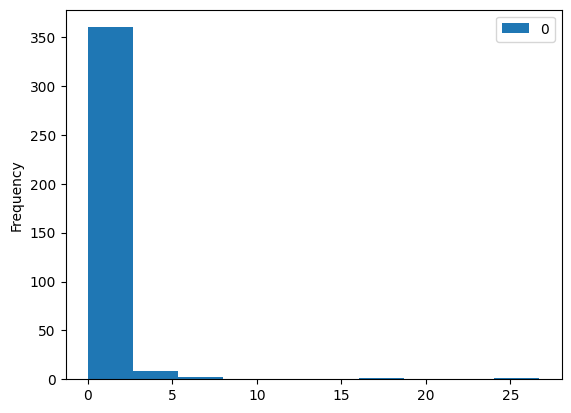

In [42]:
diff_color.plot(kind='hist')

<Axes: ylabel='Frequency'>

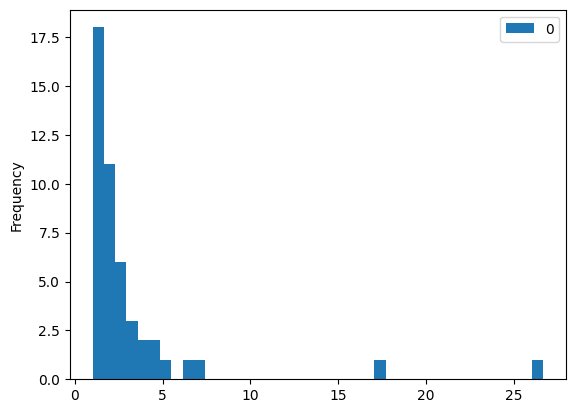

In [43]:
problem.plot(kind='hist',bins=40)

In [44]:
problem

,0
index,
88,2.209609
117,1.511046
196,1.083170
295,1.279766
398,1.521515
410,2.436455
418,2.294552
457,1.316210
486,1.328466


In [45]:
np.mean(diff_color)

0    0.683423
dtype: float32

In [46]:
#lab값을 rgb로 변경
y_test_rgb=lab_to_rgb(Y_TRANS)
y_test_rgb

,r,g,b
index,,,
1,0.564510,0.456039,0.417193
22,0.545776,0.431503,0.395676
30,0.545099,0.430658,0.396874
33,0.559013,0.447274,0.414016
39,0.863358,0.540383,0.237173
...,...,...,...
3716,0.972584,0.685724,0.011183
3718,0.966886,0.683682,0.026022
3719,0.963529,0.683181,0.042600


In [47]:
#lab값을 rgb로 변경
pred_rgb=lab_to_rgb(pred_TRANS)
pred_rgb

,r,g,b
index,,,
1,0.555599,0.447062,0.408793
22,0.549559,0.437134,0.402565
30,0.543746,0.429933,0.395859
33,0.554482,0.442642,0.408932
39,0.868274,0.548781,0.244217
...,...,...,...
3716,0.972224,0.686454,0.049969
3718,0.968527,0.682430,0.041565
3719,0.966729,0.683064,0.051839


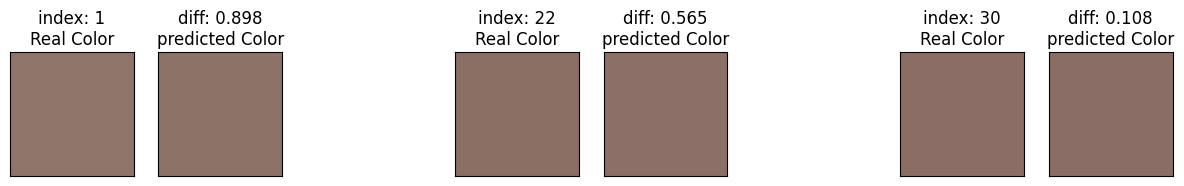

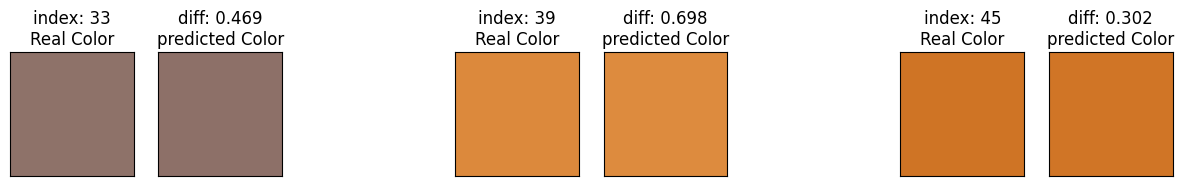

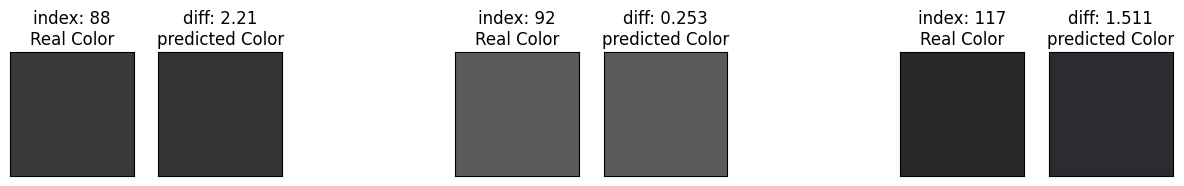

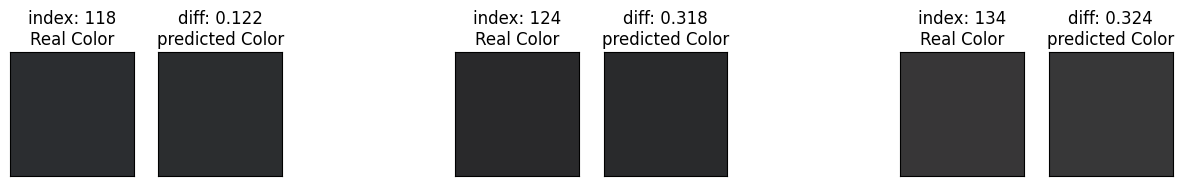

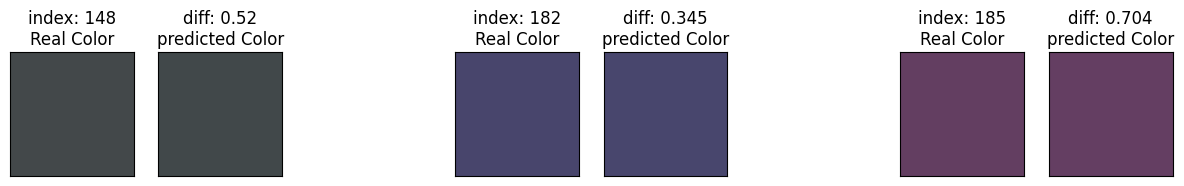

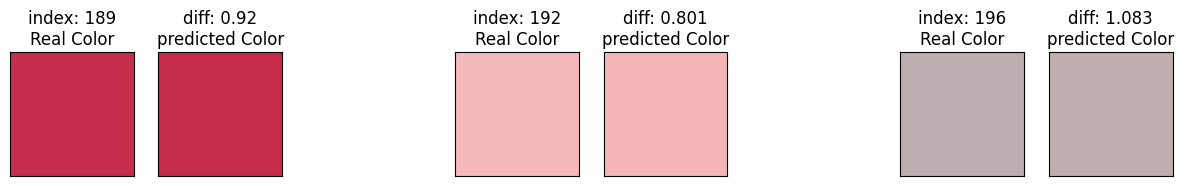

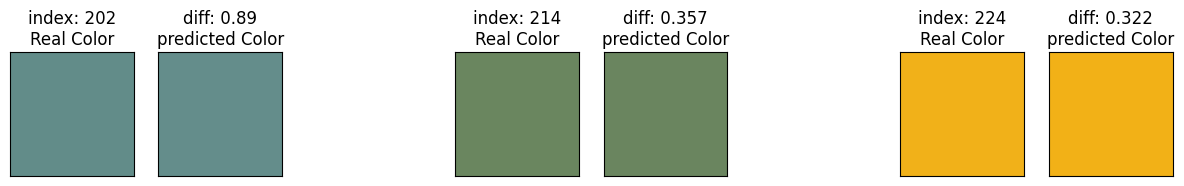

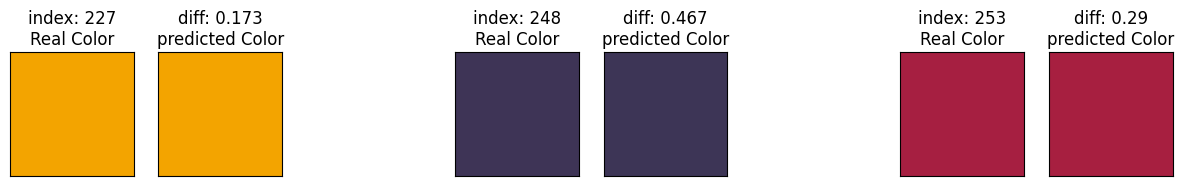

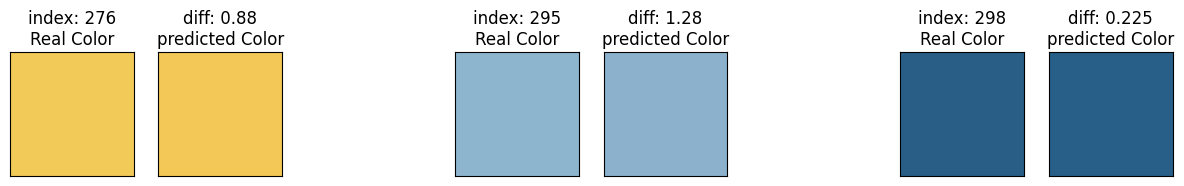

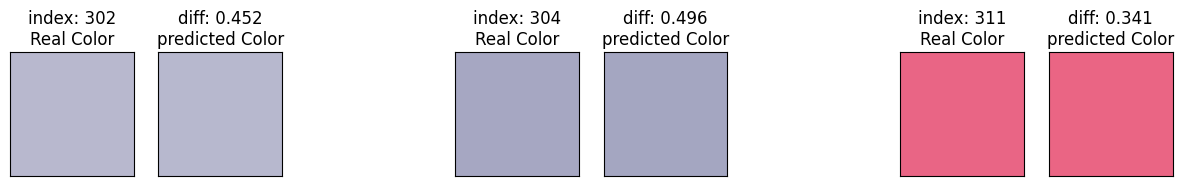

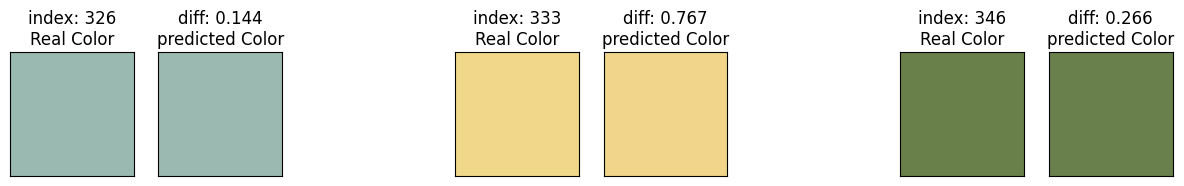

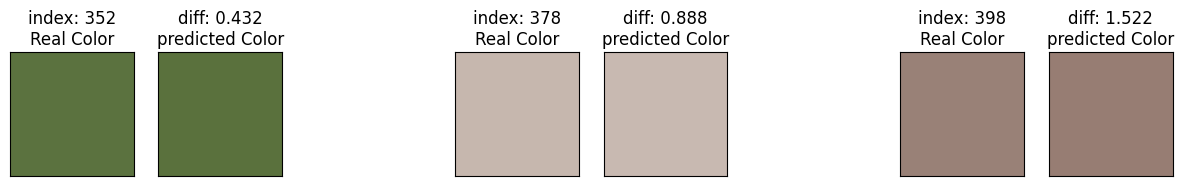

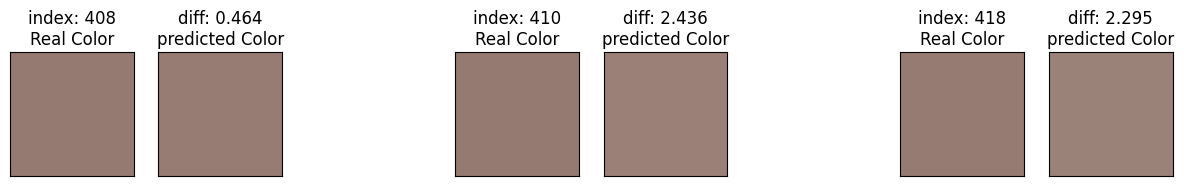

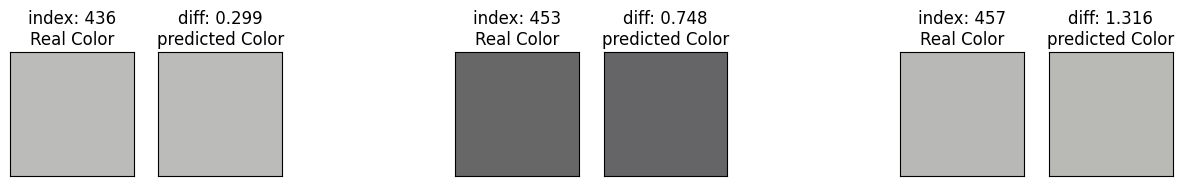

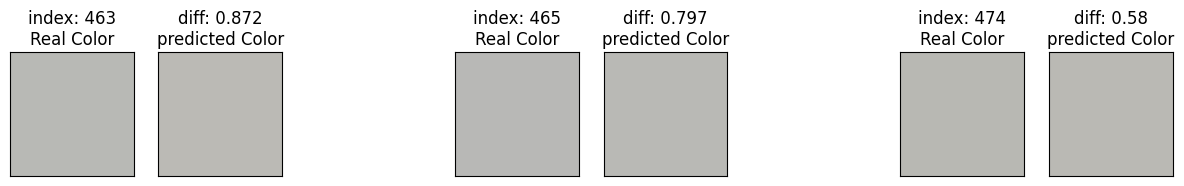

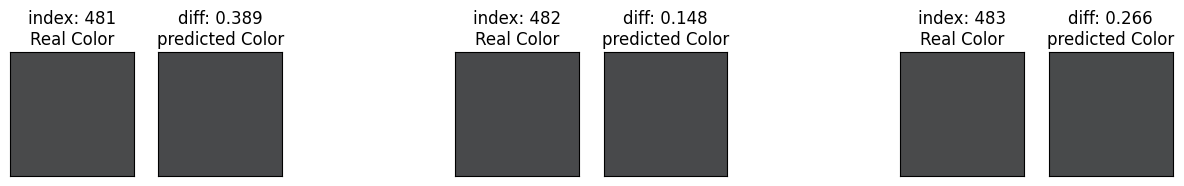

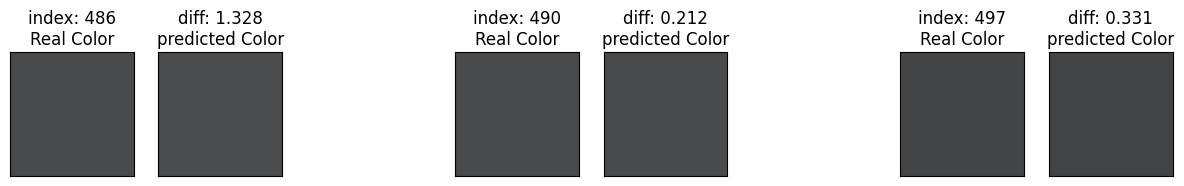

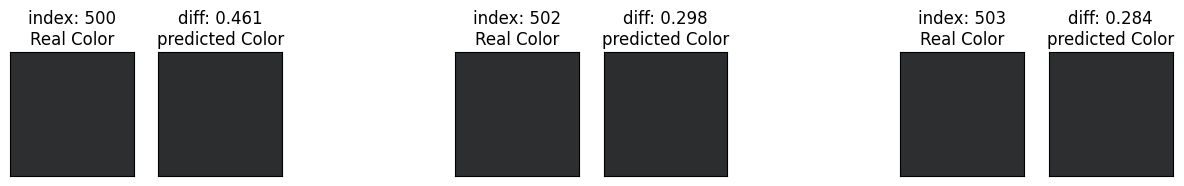

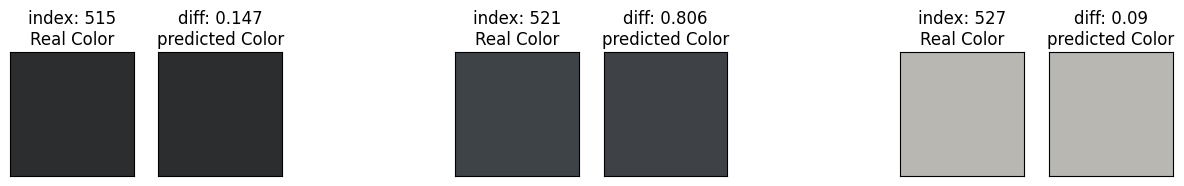

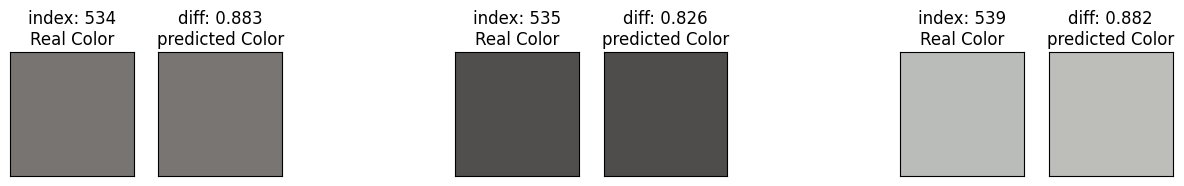

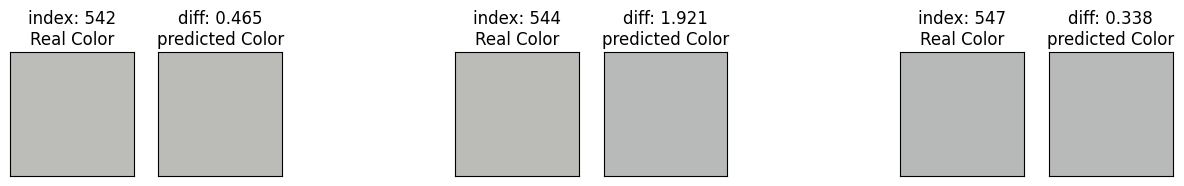

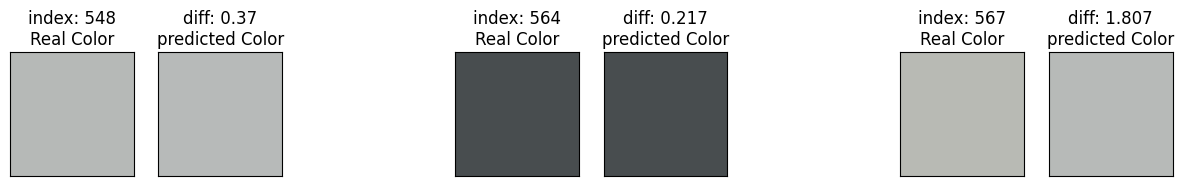

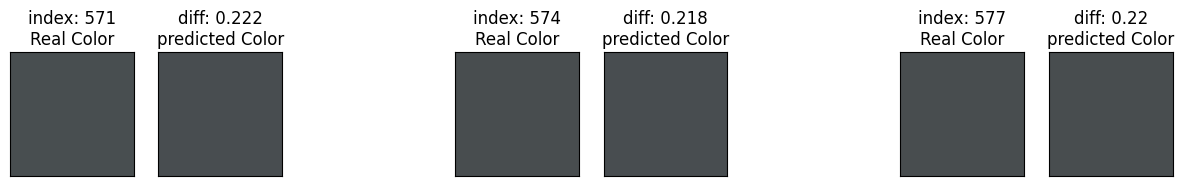

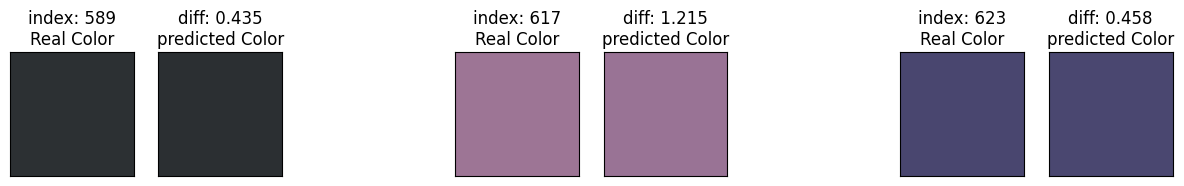

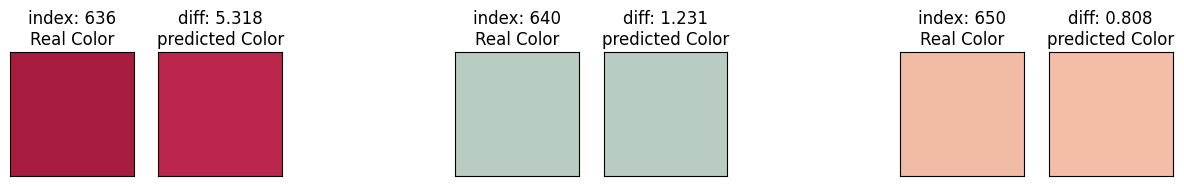

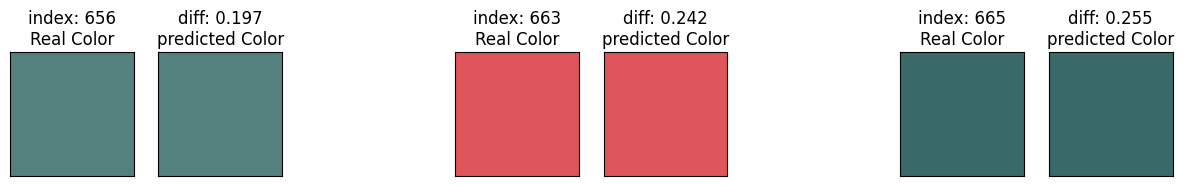

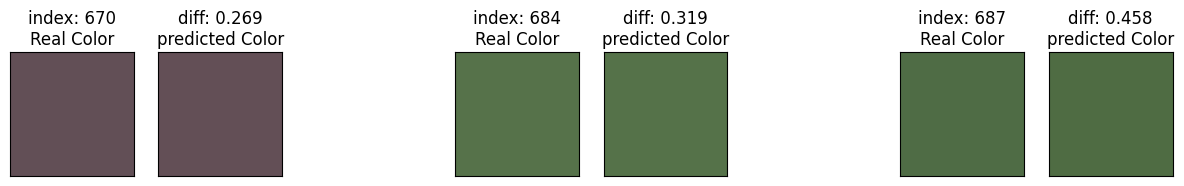

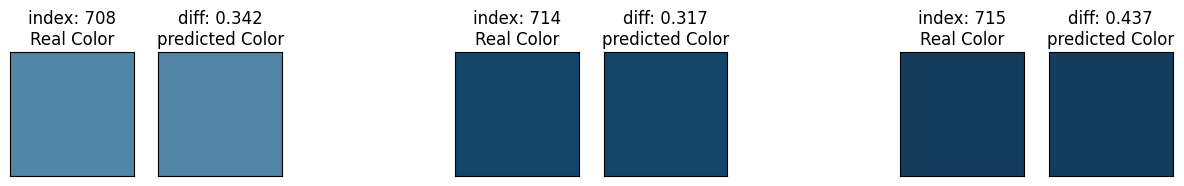

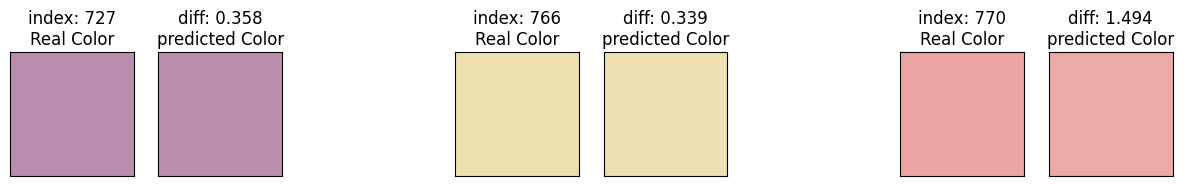

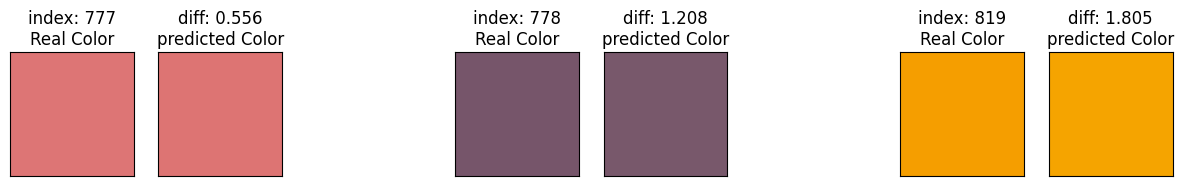

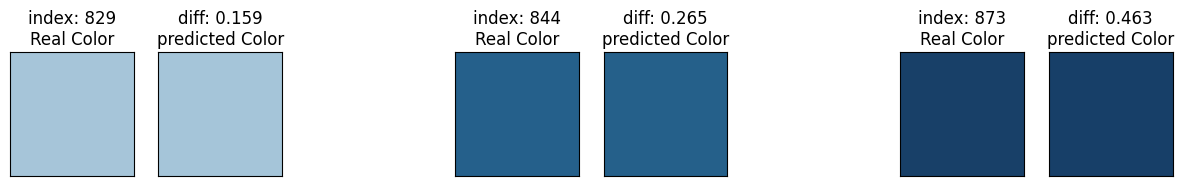

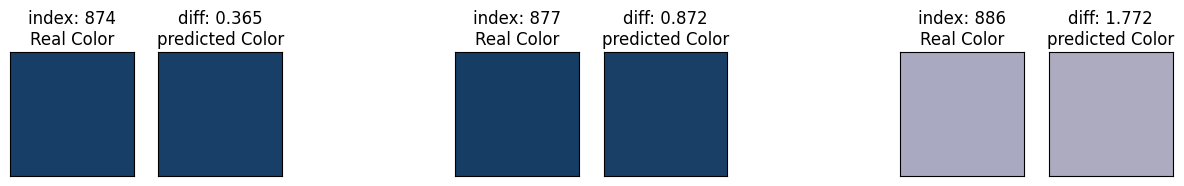

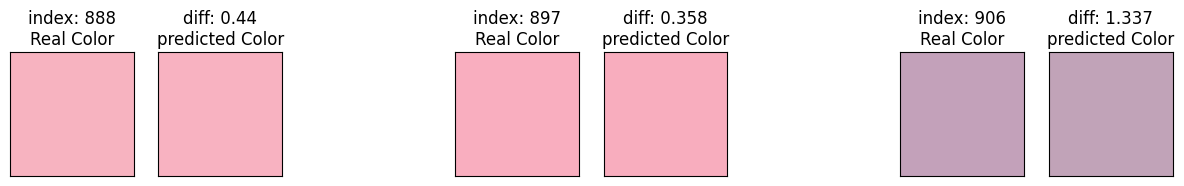

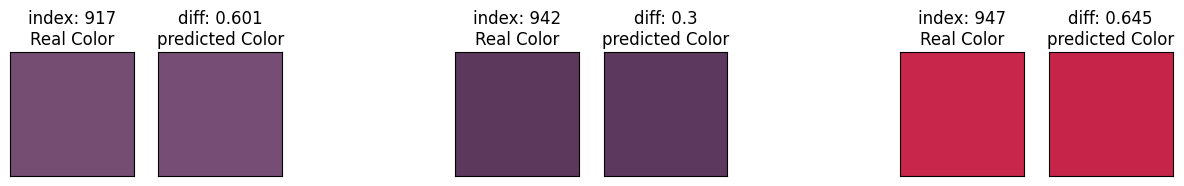

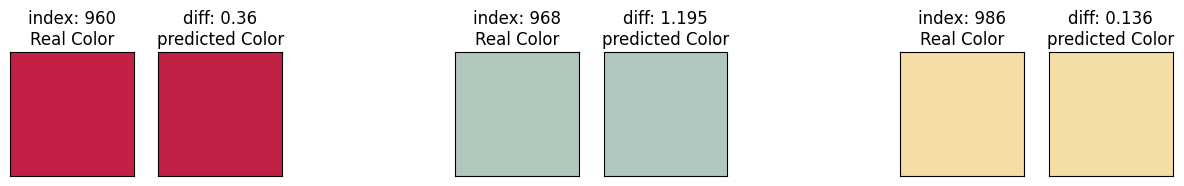

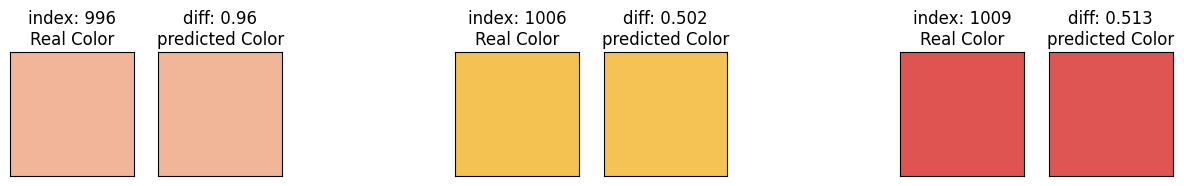

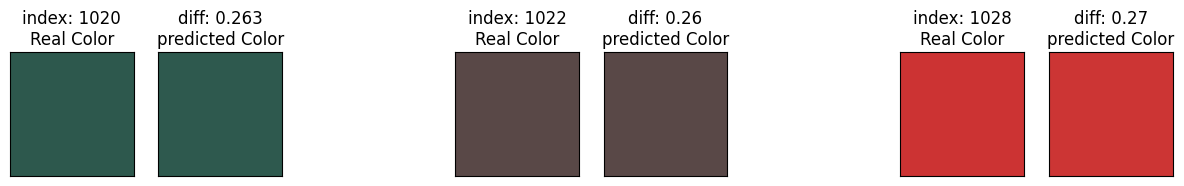

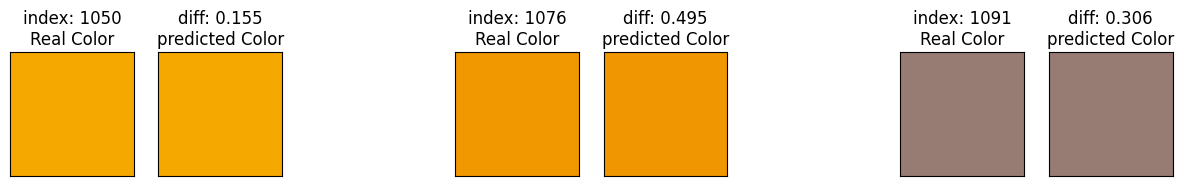

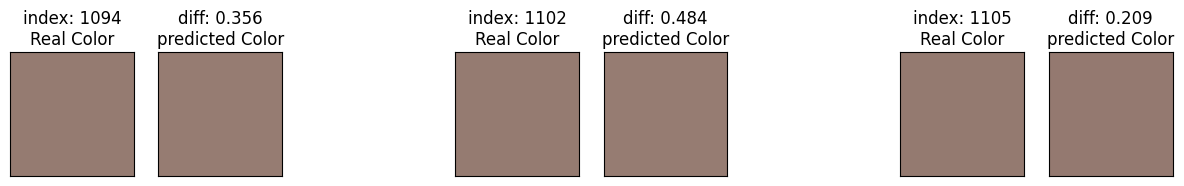

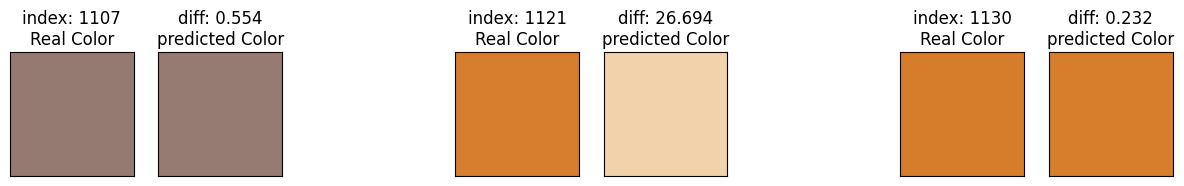

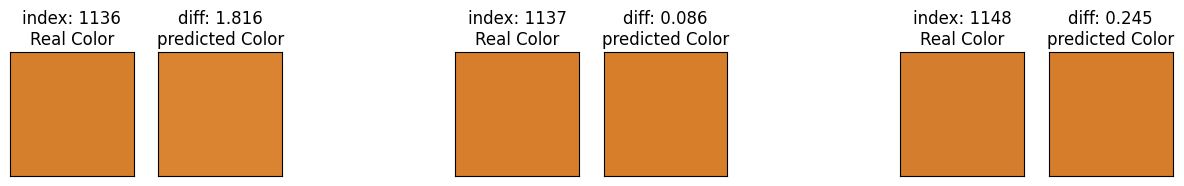

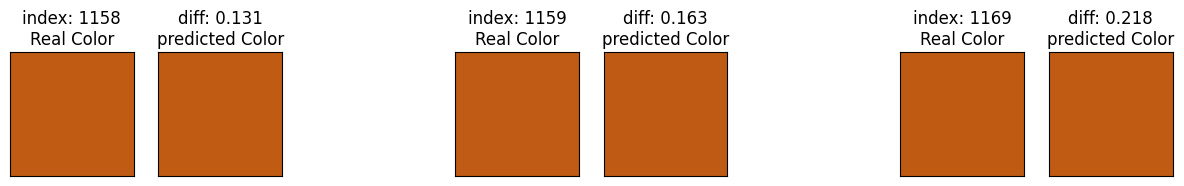

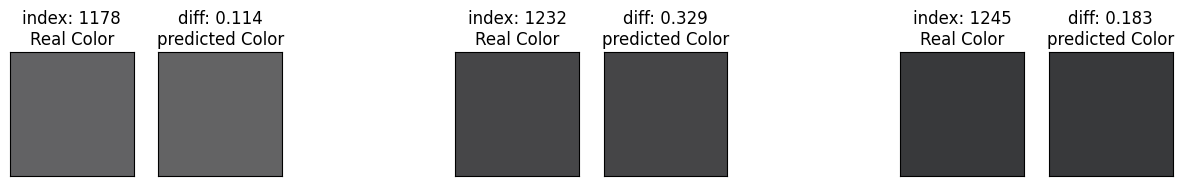

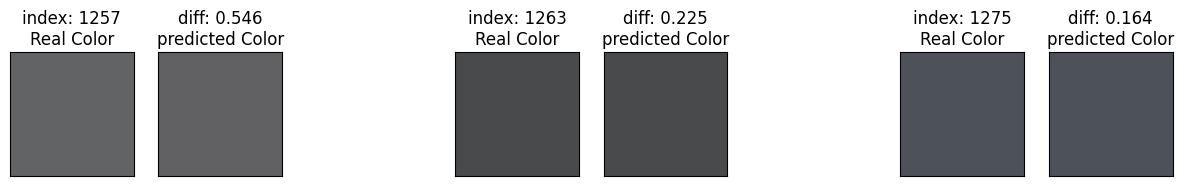

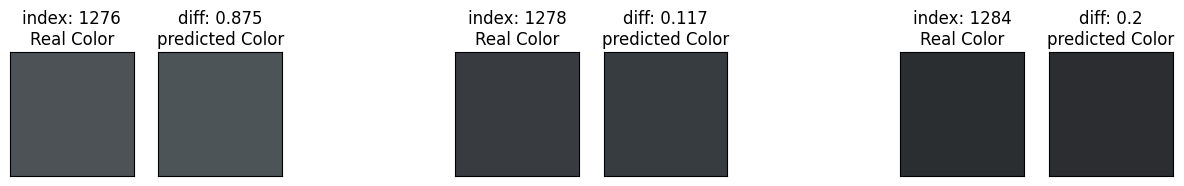

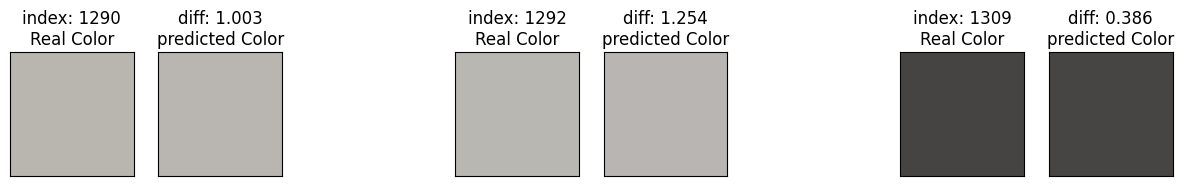

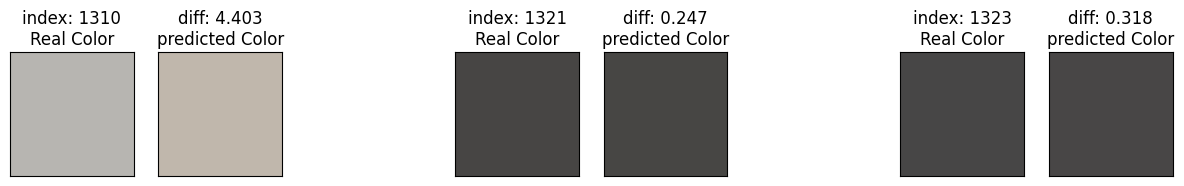

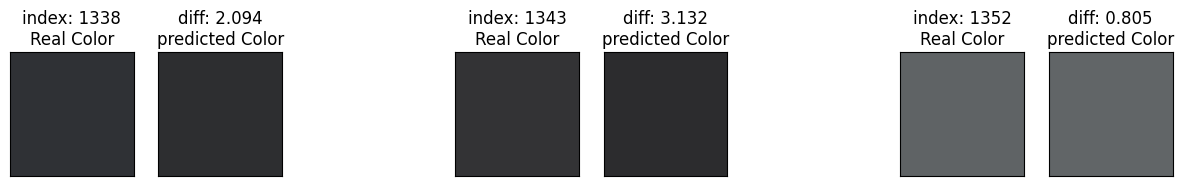

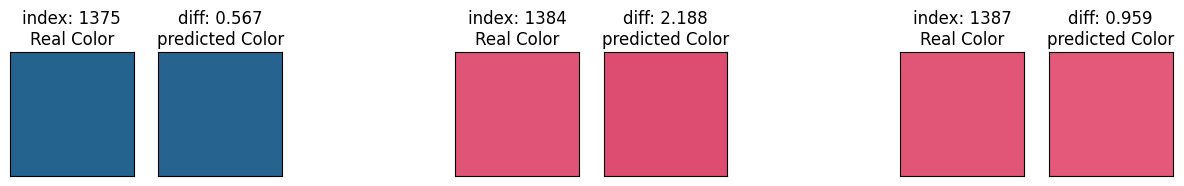

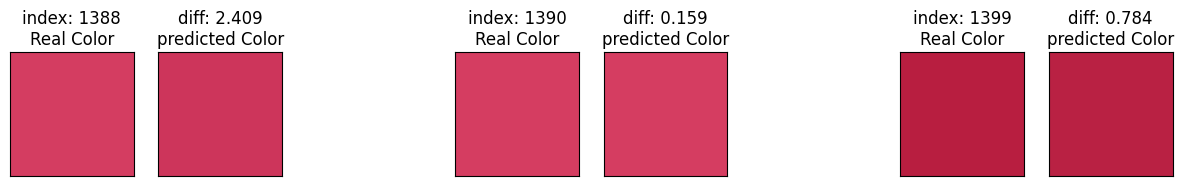

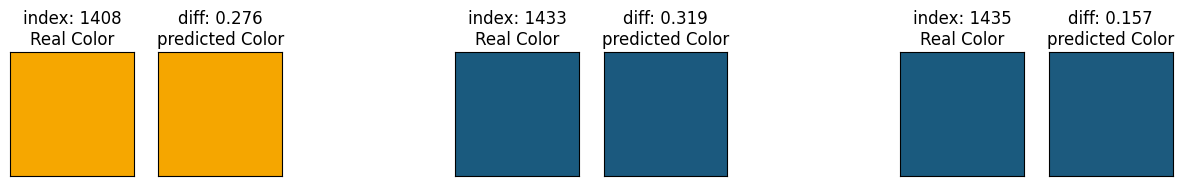

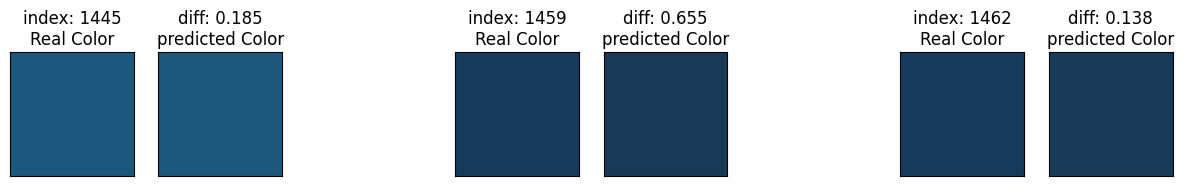

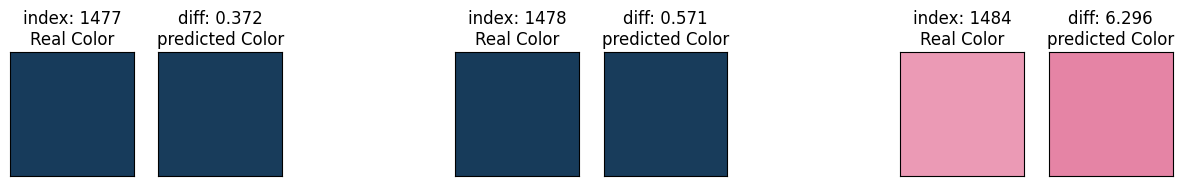

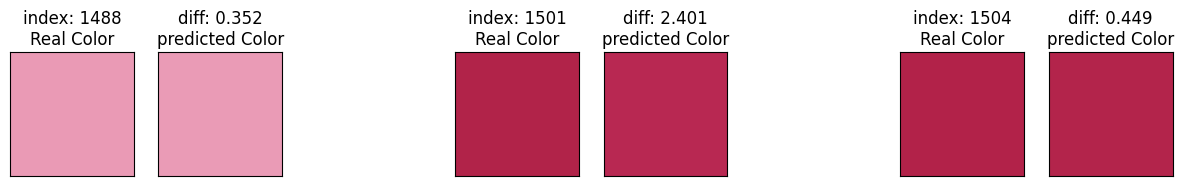

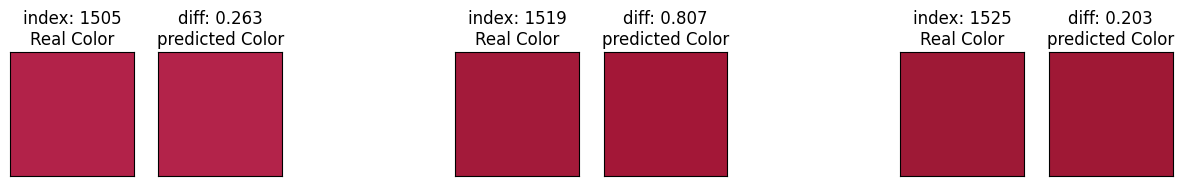

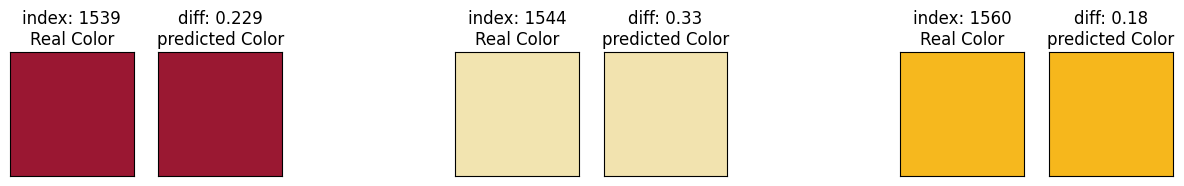

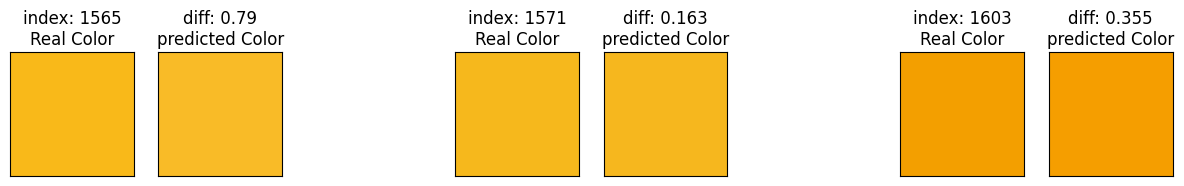

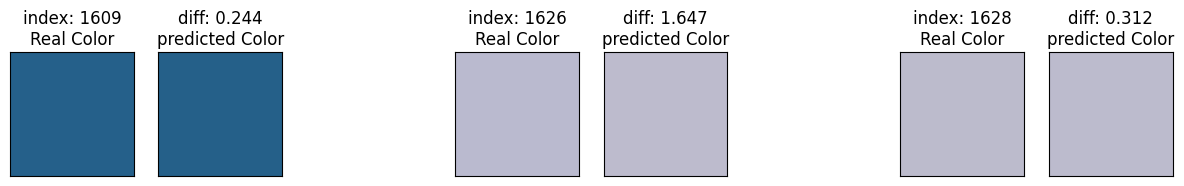

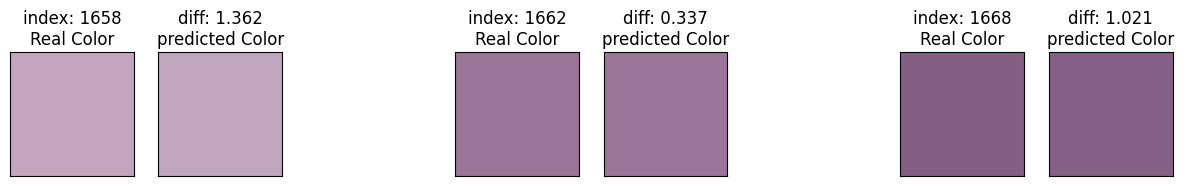

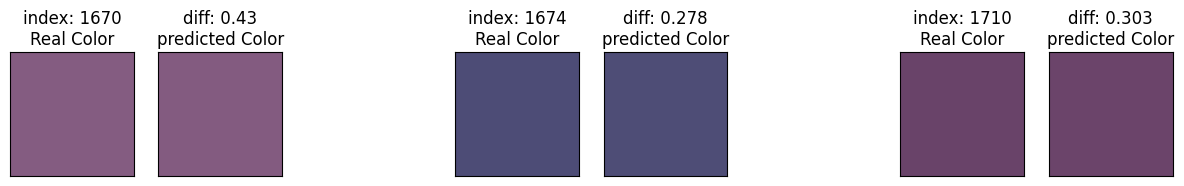

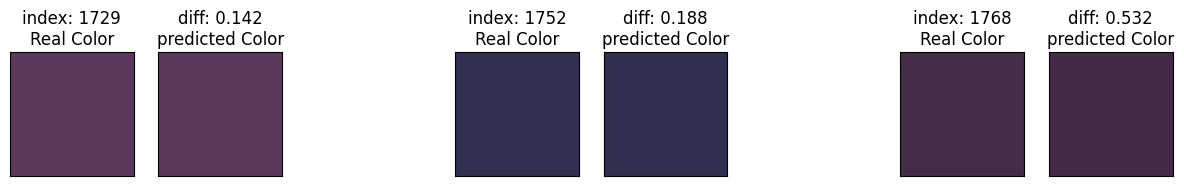

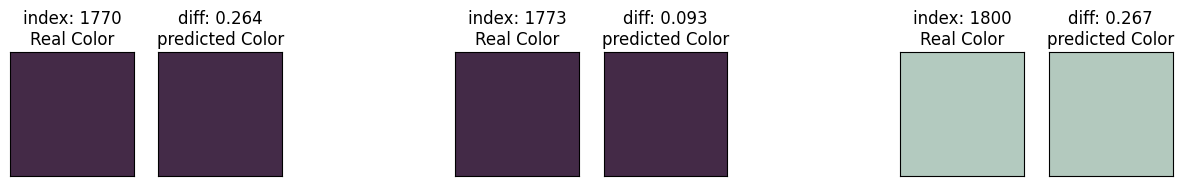

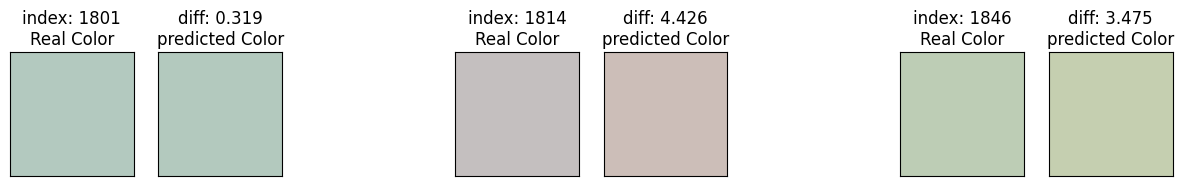

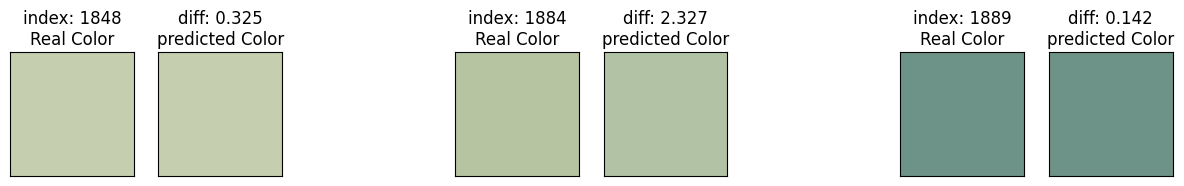

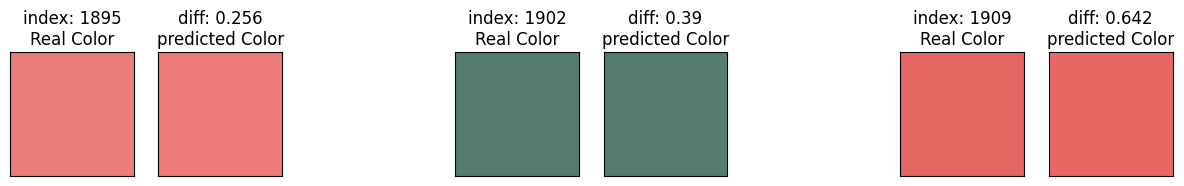

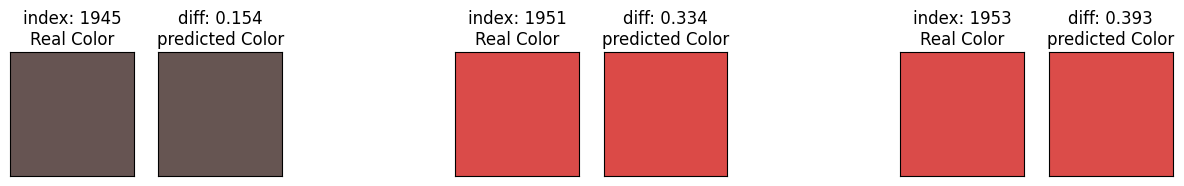

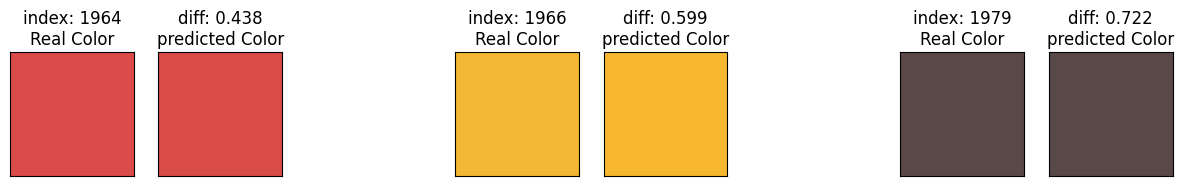

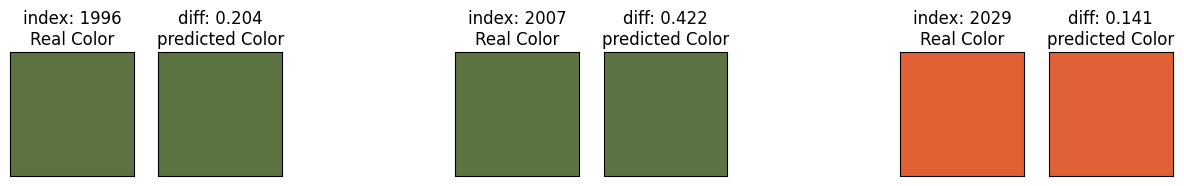

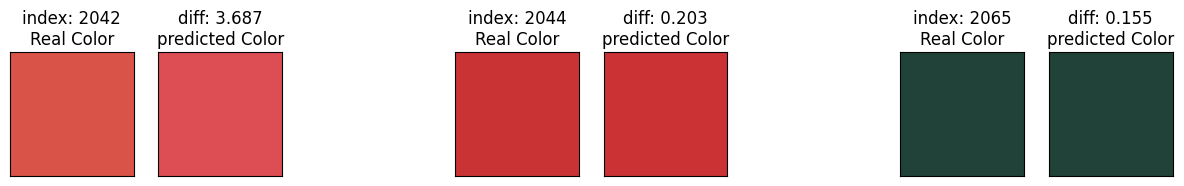

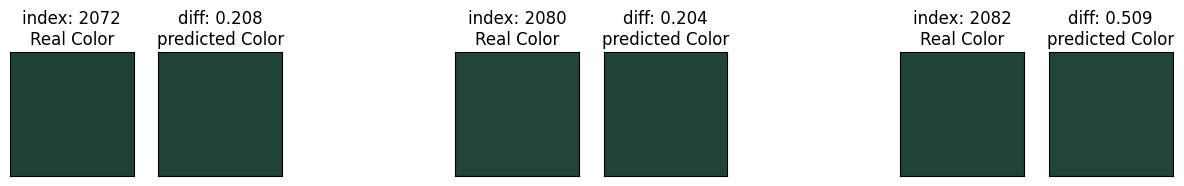

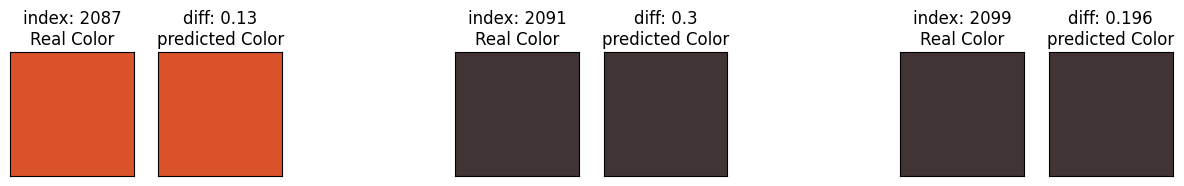

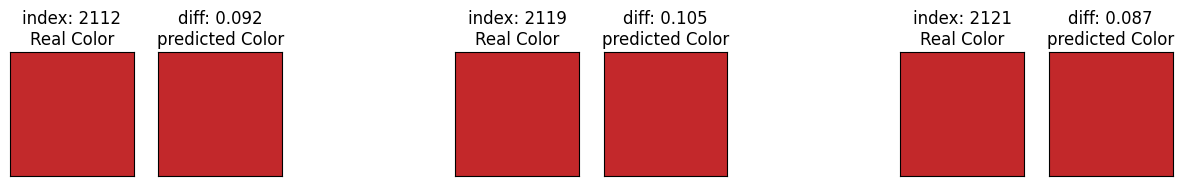

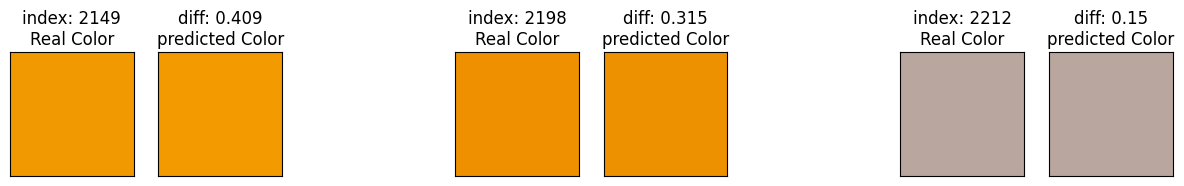

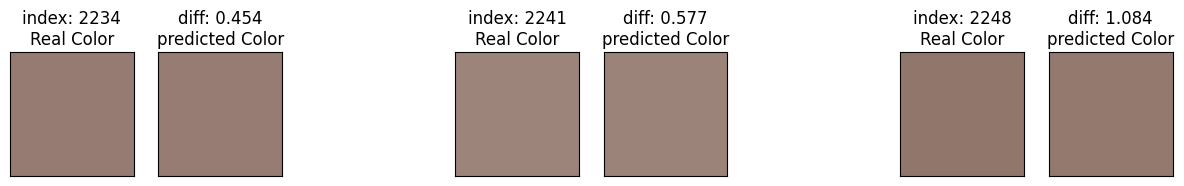

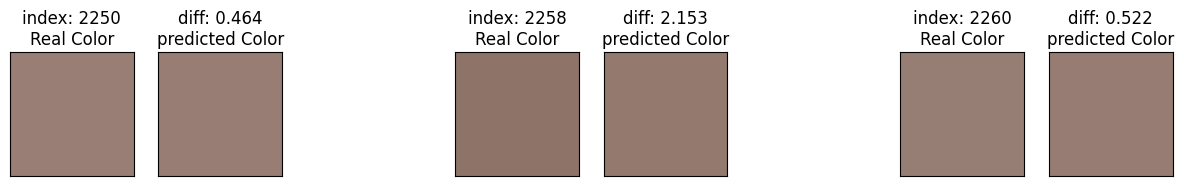

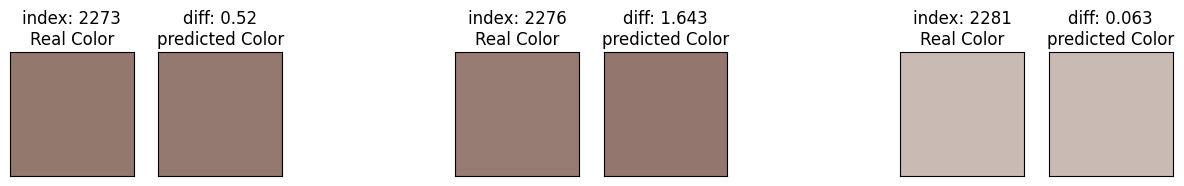

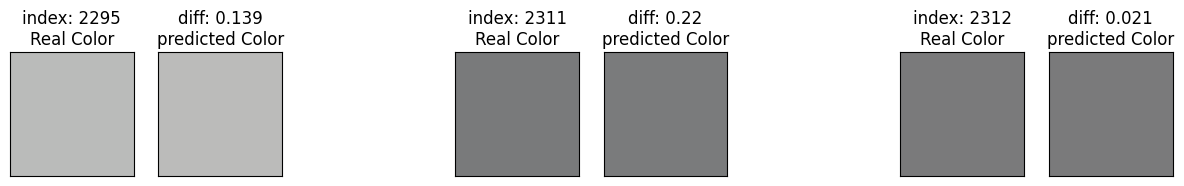

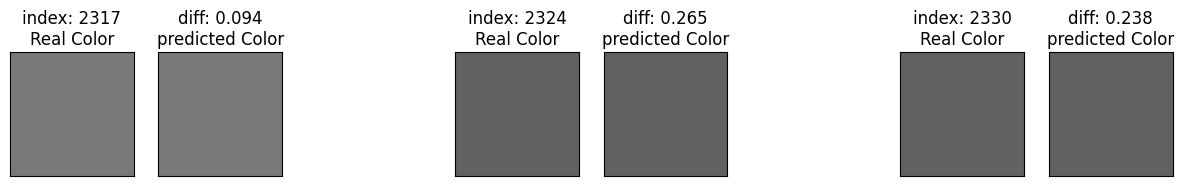

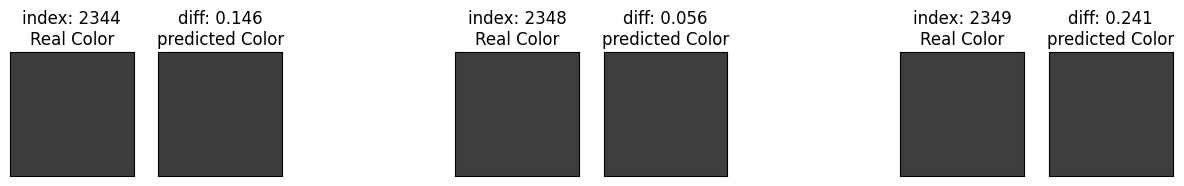

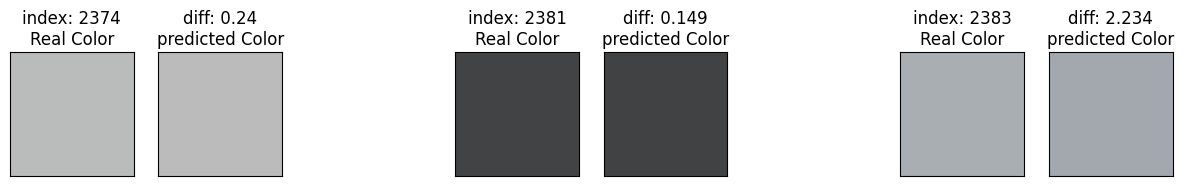

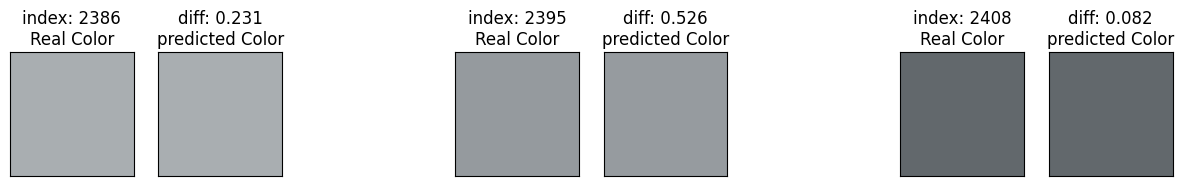

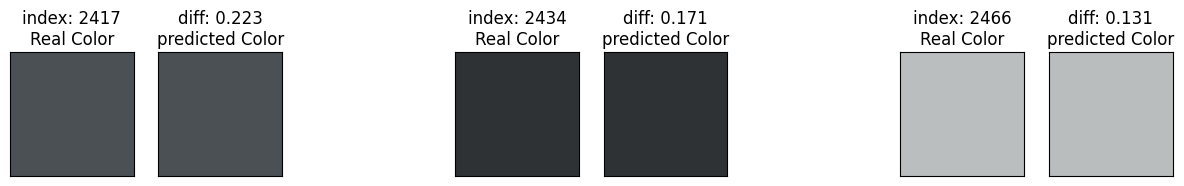

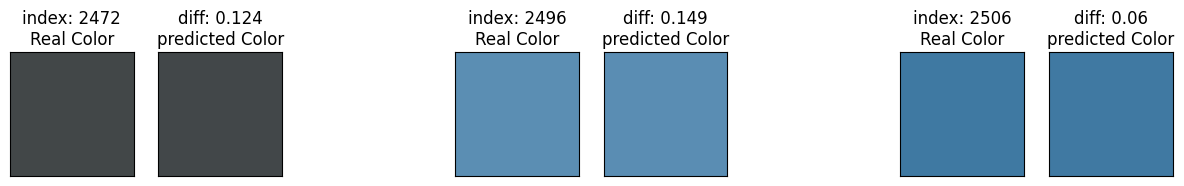

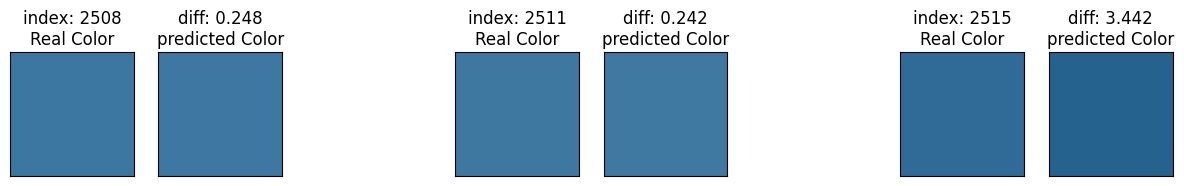

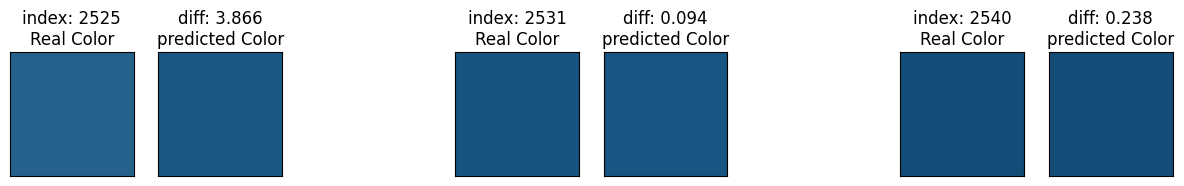

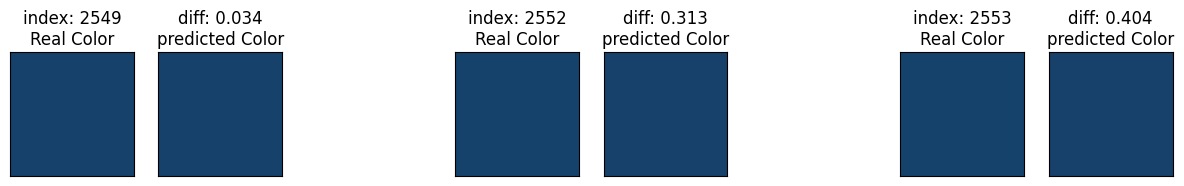

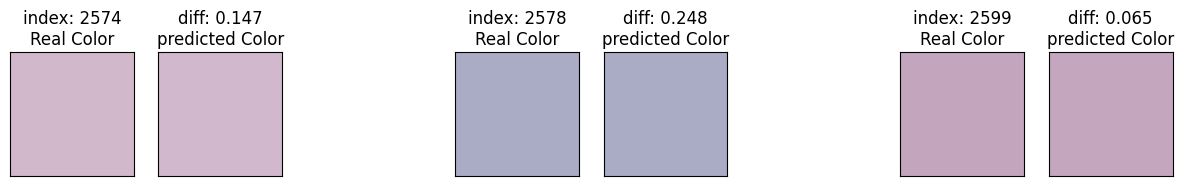

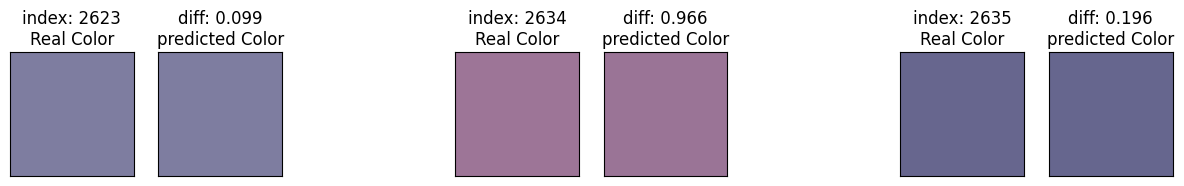

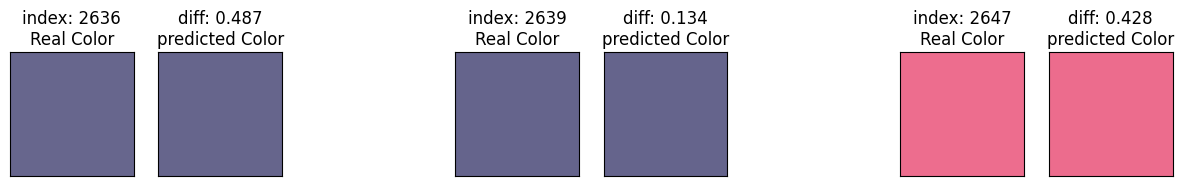

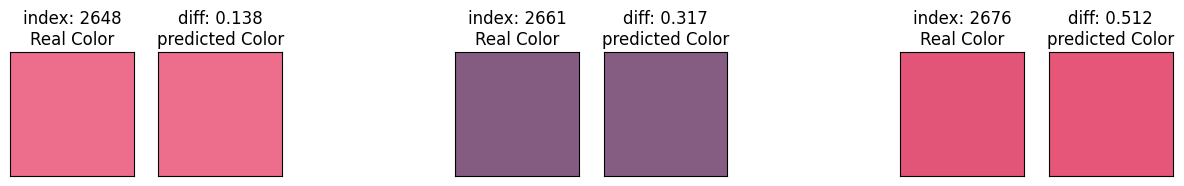

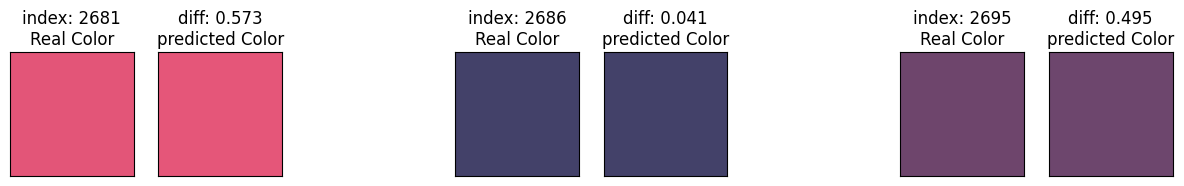

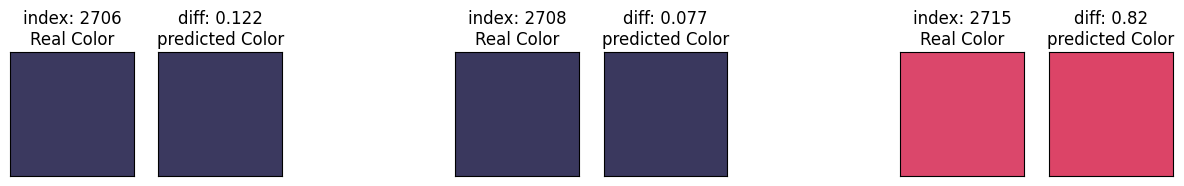

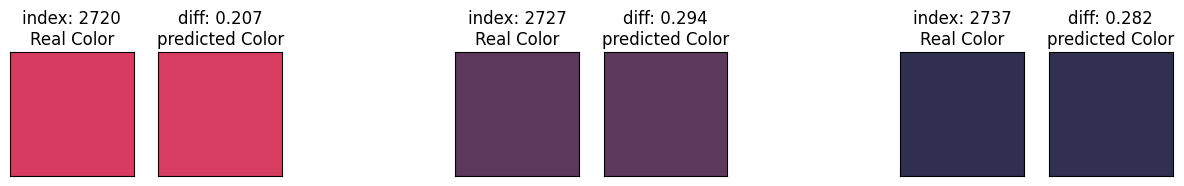

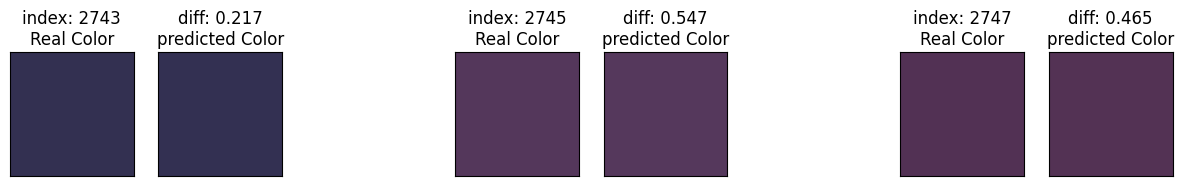

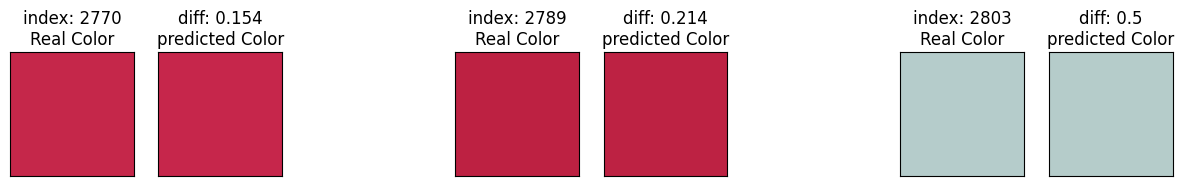

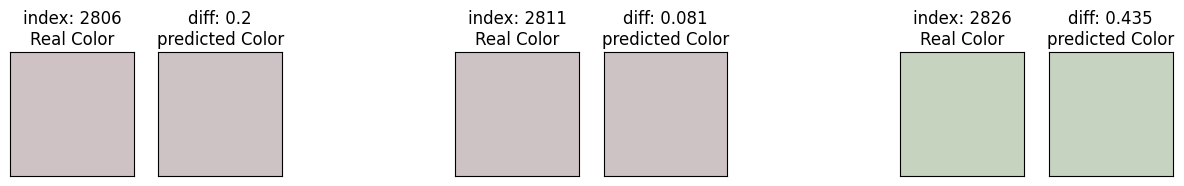

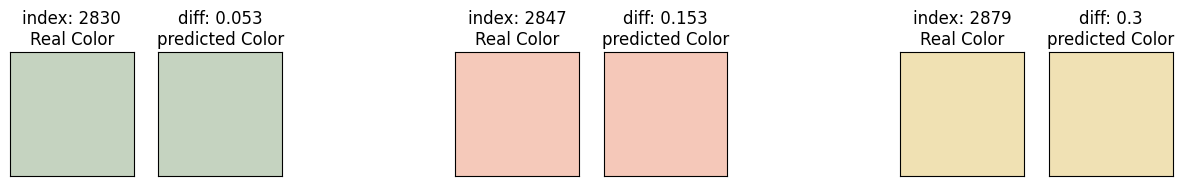

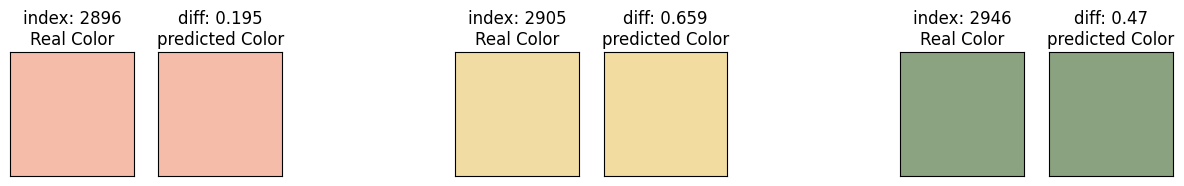

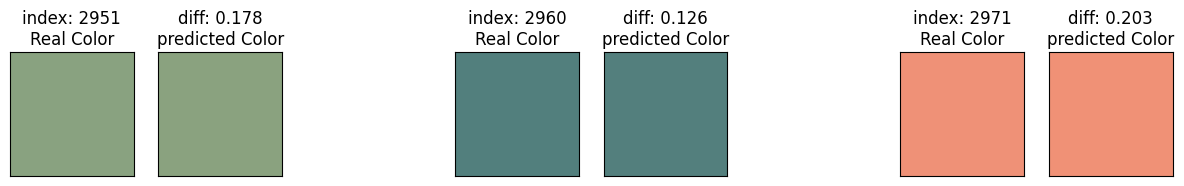

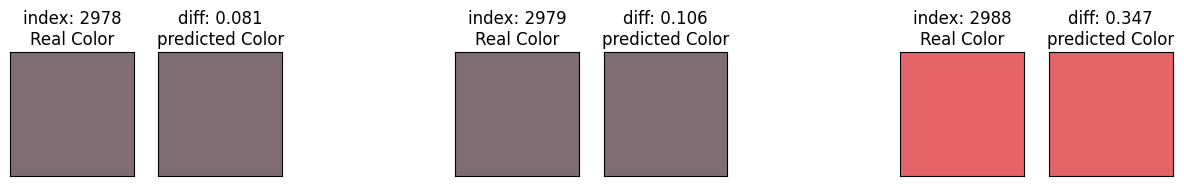

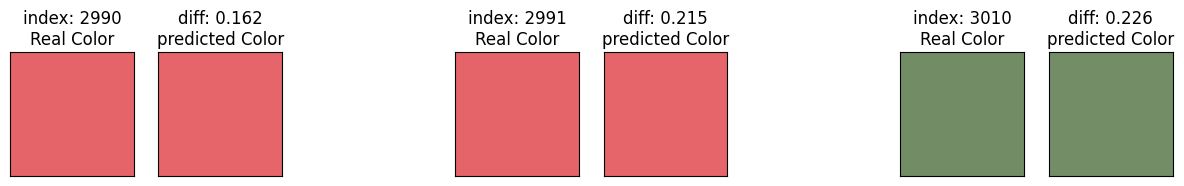

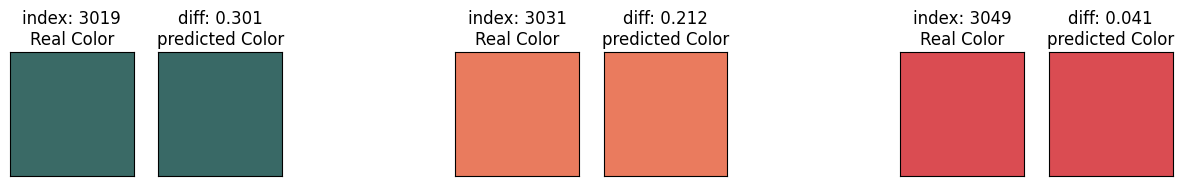

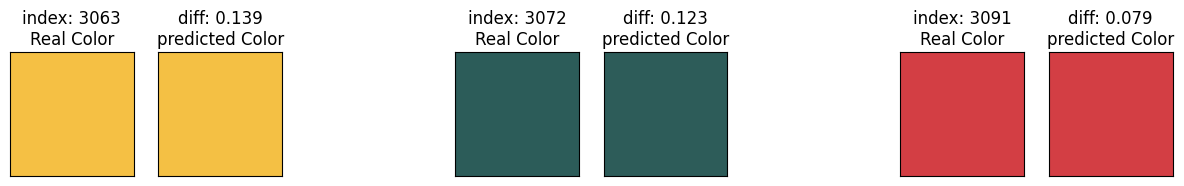

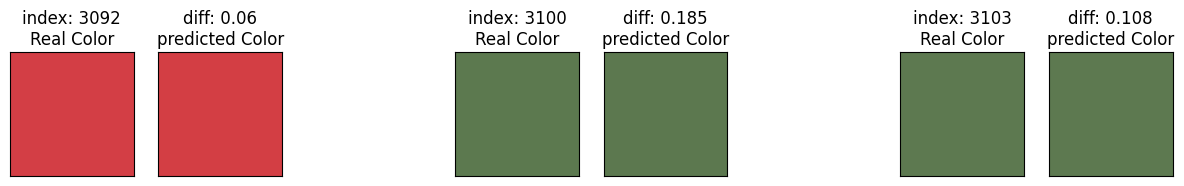

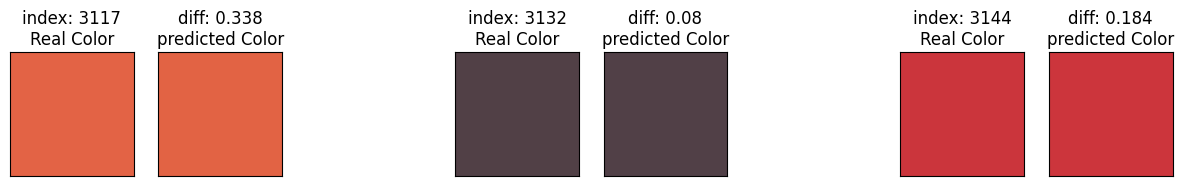

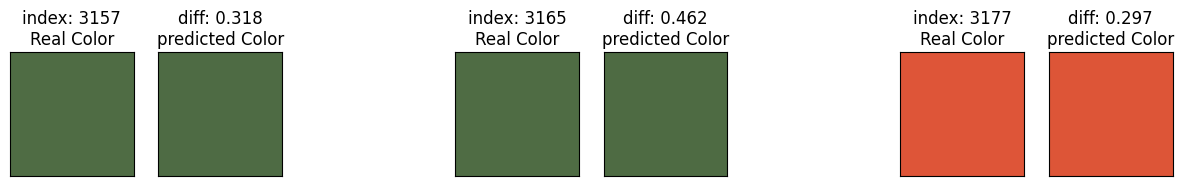

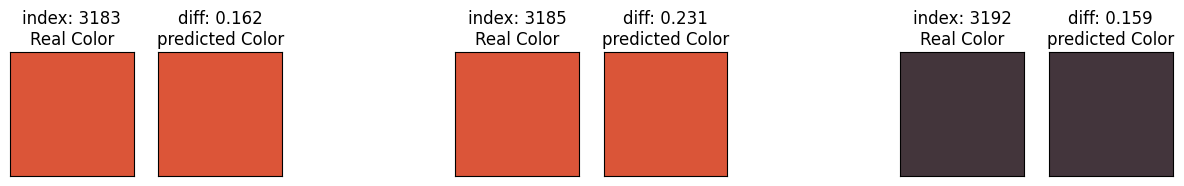

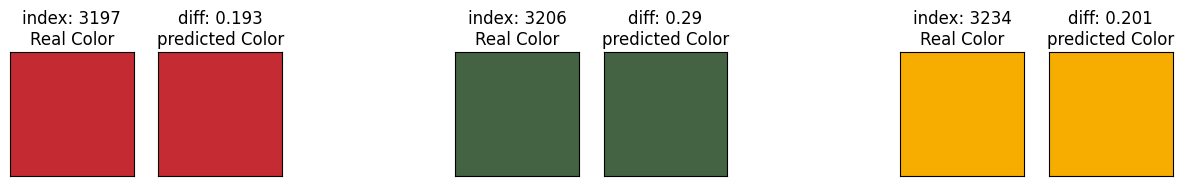

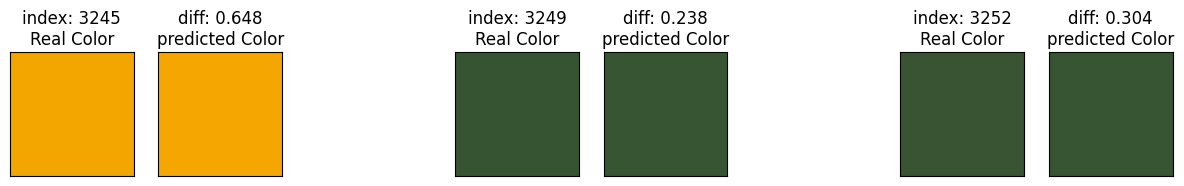

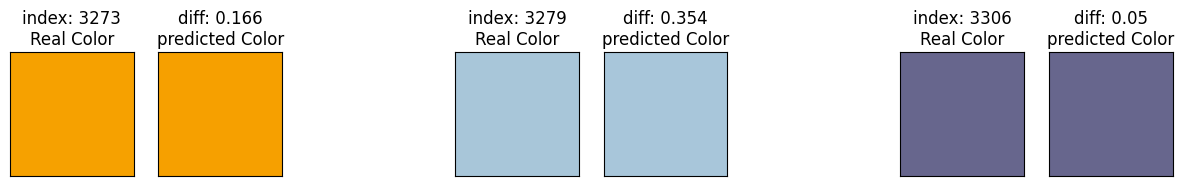

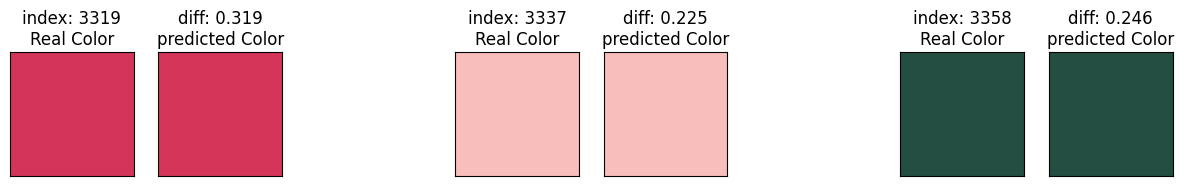

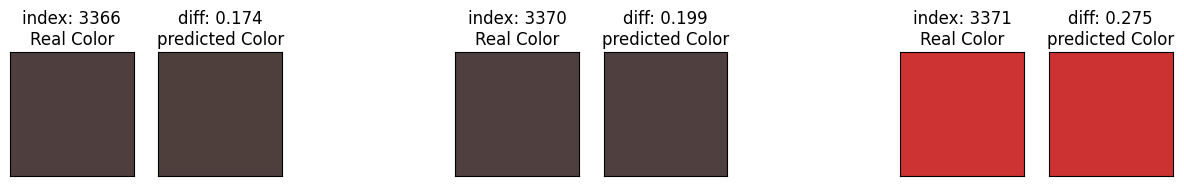

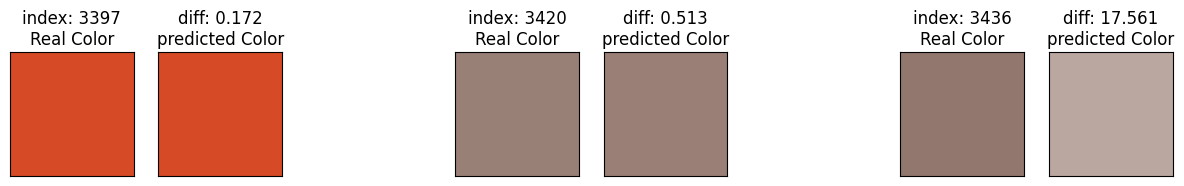

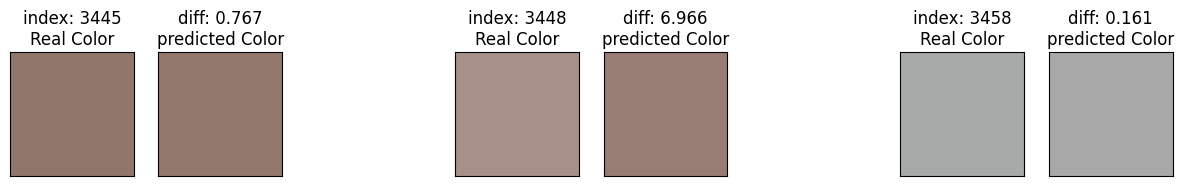

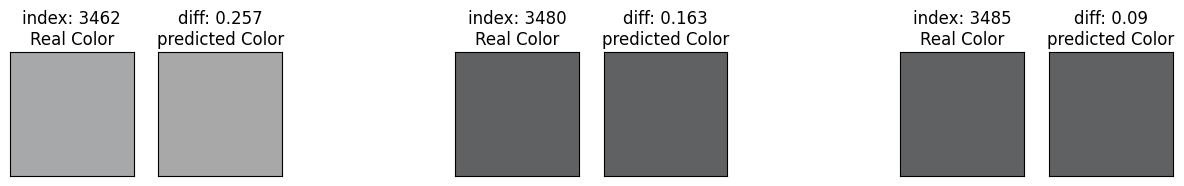

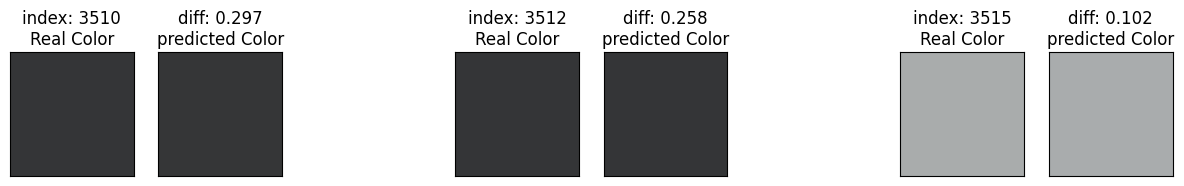

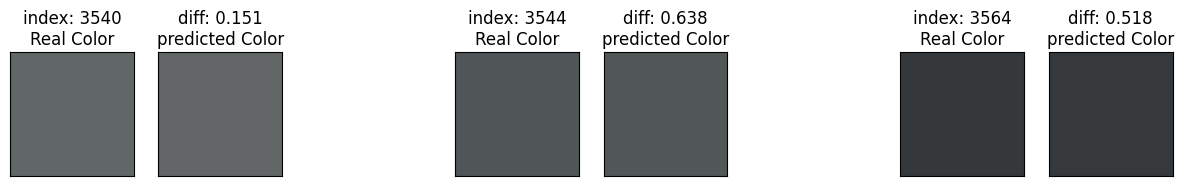

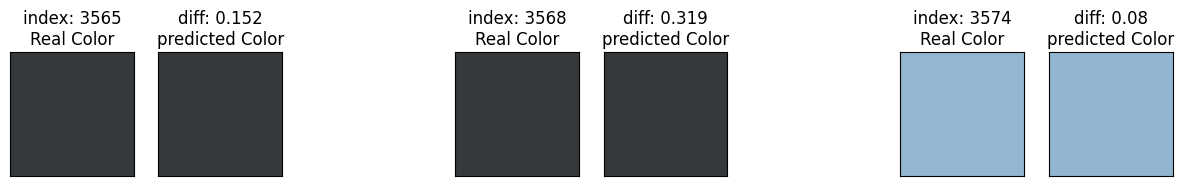

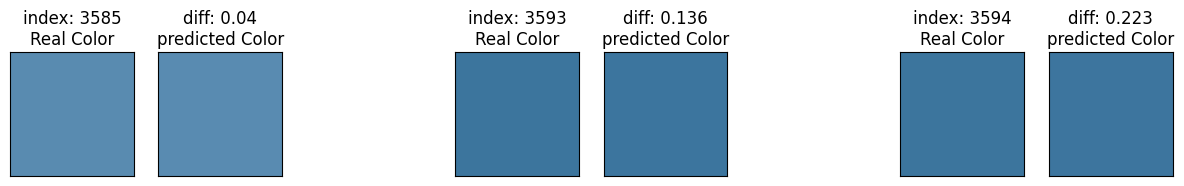

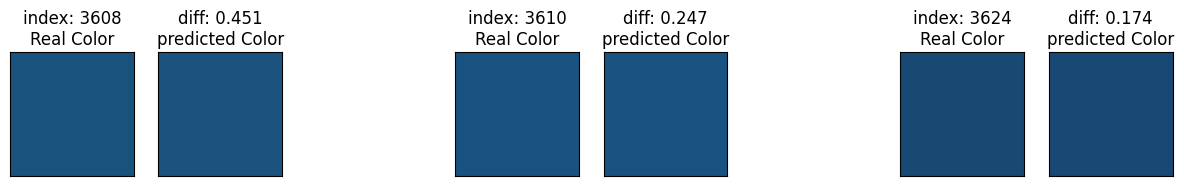

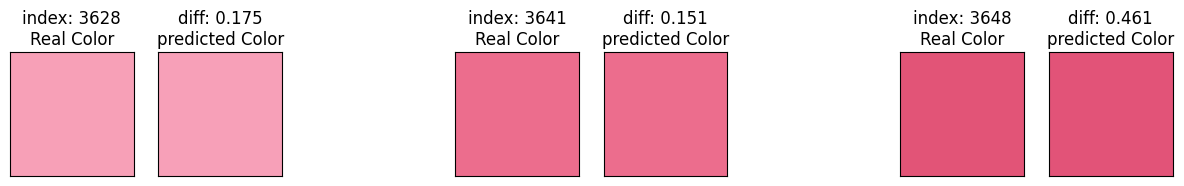

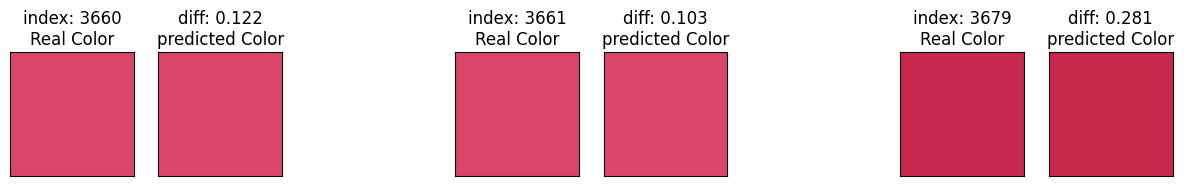

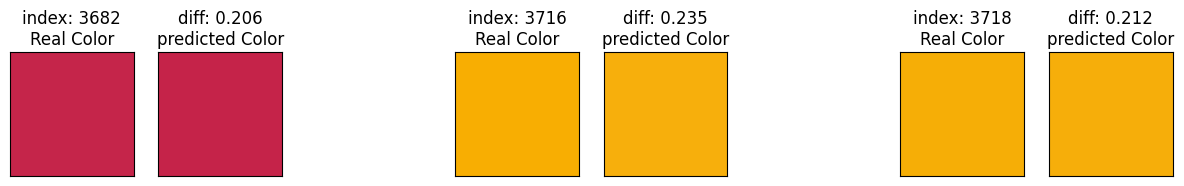

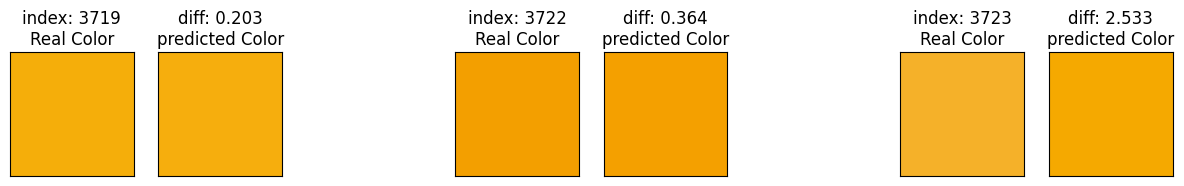

IndexError: ignored

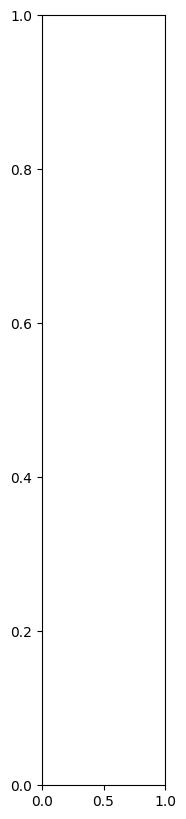

In [48]:
for i in range(len(y_test_rgb)//3+1):
    plt.figure(figsize=(15,10))
    plt.subplot(181)
    plt.imshow(Image.new("RGB", (50,50),(int(y_test_rgb['r'][y_test_rgb.index[3*i]]*255),int(y_test_rgb['g'][y_test_rgb.index[3*i]]*255),int(y_test_rgb['b'][y_test_rgb.index[3*i]]*255))))
    plt.title('index: '+str(y_test_rgb.index[3*i])+'\nReal Color')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(182)
    plt.imshow(Image.new("RGB", (50,50),(int(pred_rgb['r'][y_test_rgb.index[3*i]]*255),int(pred_rgb['g'][y_test_rgb.index[3*i]]*255),int(pred_rgb['b'][y_test_rgb.index[3*i]]*255))))
    plt.title('diff: '+str(round(diff_color.loc[diff_color.index[3*i]][0],3))+'\npredicted Color')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(184)
    plt.imshow(Image.new("RGB", (50,50),(int(y_test_rgb['r'][y_test_rgb.index[3*i+1]]*255),int(y_test_rgb['g'][y_test_rgb.index[3*i+1]]*255),int(y_test_rgb['b'][y_test_rgb.index[3*i+1]]*255))))
    plt.title('index: '+str(y_test_rgb.index[3*i+1])+'\nReal Color')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(185)
    plt.imshow(Image.new("RGB", (50,50),(int(pred_rgb['r'][y_test_rgb.index[3*i+1]]*255),int(pred_rgb['g'][y_test_rgb.index[3*i+1]]*255),int(pred_rgb['b'][y_test_rgb.index[3*i+1]]*255))))
    plt.title('diff: '+str(round(diff_color.loc[diff_color.index[3*i+1]][0],3))+'\npredicted Color')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(187)
    plt.imshow(Image.new("RGB", (50,50),(int(y_test_rgb['r'][y_test_rgb.index[3*i+2]]*255),int(y_test_rgb['g'][y_test_rgb.index[3*i+2]]*255),int(y_test_rgb['b'][y_test_rgb.index[3*i+2]]*255))))
    plt.title('index: '+str(y_test_rgb.index[3*i+2])+'\nReal Color')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(188)
    plt.imshow(Image.new("RGB", (50,50),(int(pred_rgb['r'][y_test_rgb.index[3*i+2]]*255),int(pred_rgb['g'][y_test_rgb.index[3*i+2]]*255),int(pred_rgb['b'][y_test_rgb.index[3*i+2]]*255))))
    plt.title('diff: '+str(round(diff_color.loc[diff_color.index[3*i+2]][0],3))+'\npredicted Color')
    plt.xticks([])
    plt.yticks([])
    plt.show()